In [4]:
import sys
import os

# Get the parent directory of the notebook (project root)
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from dotenv import load_dotenv

load_dotenv()

In [5]:
import os

if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0  # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os

    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel("ERROR")

# Set random seed for reproducibility
sionna.config.seed = 42

In [3]:
import time
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sionna.channel import (
    ApplyOFDMChannel,
    ApplyTimeChannel,
    cir_to_ofdm_channel,
    cir_to_time_channel,
    gen_single_sector_topology,
    subcarrier_frequencies,
    time_lag_discrete_time_channel,
)
from sionna.channel.tr38901 import CDL, AntennaArray, UMi
from sionna.utils import ebnodb2no
from tqdm import tqdm

from src.channels.cdl_channel import (
    cdl,
    channel_frequency_domain,
    channel_time_domain,
    frequencies,
    no,
    sampling_channel_freq,
    sampling_channel_time,
)
from src.channels.channel_est.ls_channel import ChannelEstimator
from src.channels.channel_est.ml_channel import VAE
from src.channels.lmmse_equalizer import lmmse_equalizer
from src.data.binary_sources import binary_sources
from src.data.qam_demapper import qam_demapper
from src.data.qam_mapper import qam_mapper
from src.data.response import response_freqency_domain, response_time_domain
from src.evals.ber import ber
from src.ldpc.ldpc_decoder import ldpc_decoder
from src.ldpc.ldpc_encoder import ldpc_encoder
from src.ml.gen_data import (
    get_pilot_matrix,
    remove_nulls_subcarriers,
    synthesys_training_data,
)
from src.ml.transform import MinMaxScaler4D
from src.ml.utils import (
    compute_mean_std,
    nmse_func,
    plot_distribution_vae,
    reshape_data,
    reversed_reshape_data,
)
from src.ofdm.ofdm_demodulation import ofdm_demodulation
from src.ofdm.ofdm_modulation import ofdm_modulation
from src.ofdm.ofdm_resource_grids import resource_grid_mapper, rg
from src.settings.antenna import bs_array, ut_array
from src.settings.config import (
    bandwidth,
    batch_size,
    bits_per_symbol,
    carrier_frequency,
    cdl_model,
    code_rate,
    cyclic_prefix_length,
    delay_spread,
    direction,
    ebno_db,
    num_bs_ant,
    num_effective_subcarriers,
    num_ofdm_symbols,
    num_rx,
    num_streams_per_tx,
    num_subcarrier,
    num_tx,
    num_ut_ant,
    number_of_bits,
    speed,
)
from src.settings.ml import device, number_of_samples
from src.utils.plots import plot_channel_frequency_domain, plot_symbols

# Antenna Setting

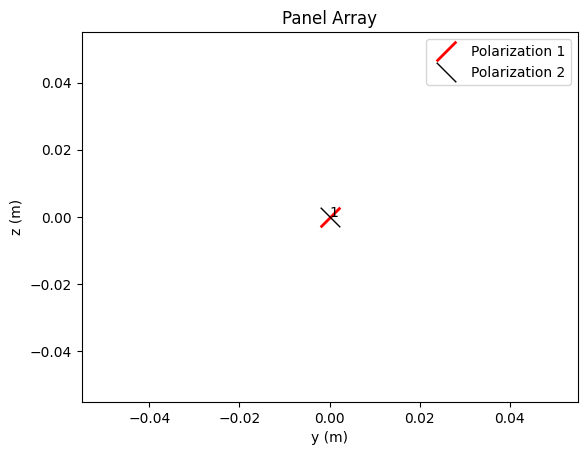

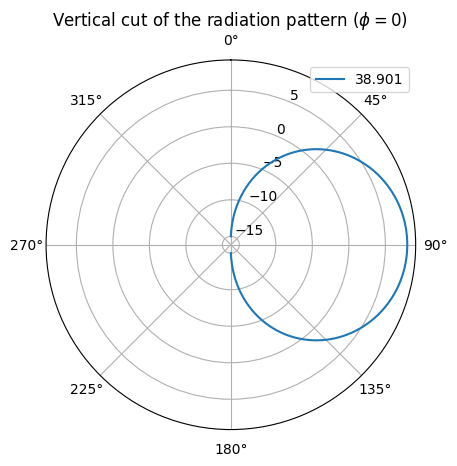

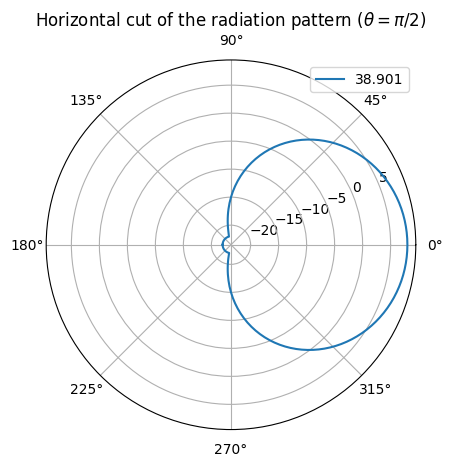

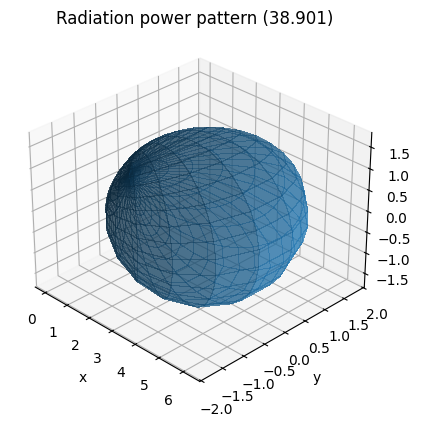

In [4]:
# UT array
ut_array.show()
ut_array.show_element_radiation_pattern()
plt.show()

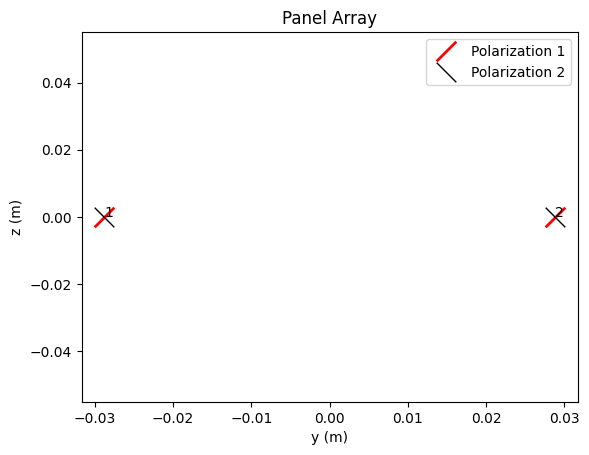

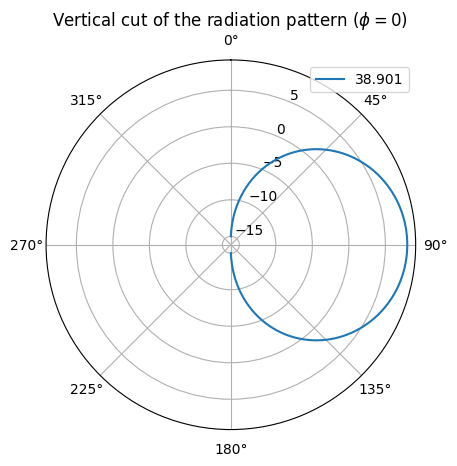

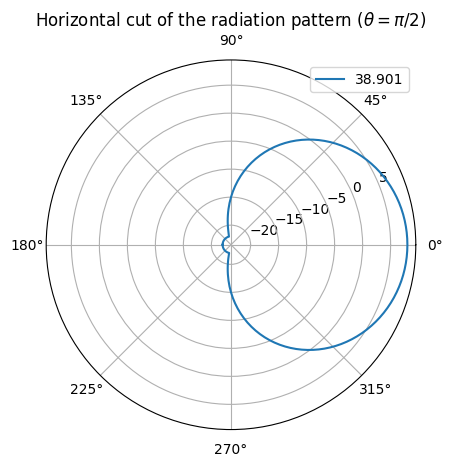

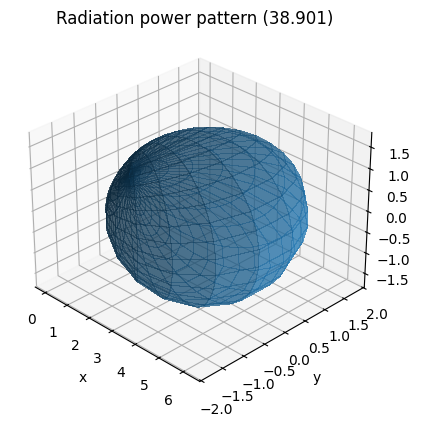

In [5]:
# BS array
bs_array.show()
bs_array.show_element_radiation_pattern()
plt.show()

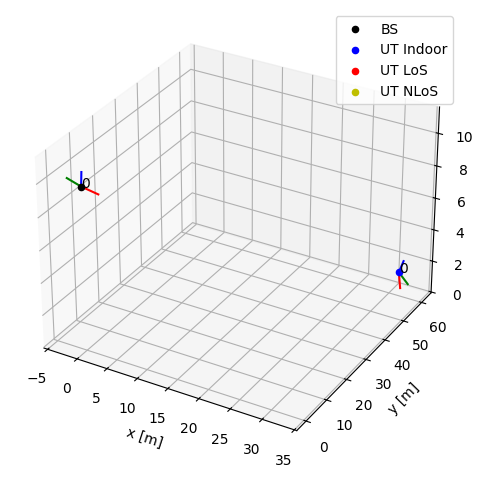

In [6]:
topology = gen_single_sector_topology(1, 1, "umi", min_ut_velocity=speed)
ut_loc, bs_loc, ut_orientations, bs_orientations, ut_velocities, in_state = topology

umi = UMi(
    carrier_frequency=carrier_frequency,
    o2i_model="low",
    ut_array=ut_array,
    bs_array=bs_array,
    direction="uplink",
    enable_shadow_fading=False,
    enable_pathloss=True,
)
umi.set_topology(
    ut_loc, bs_loc, ut_orientations, bs_orientations, ut_velocities, in_state
)
umi.show_topology()
plt.show()

# Signal Modelling

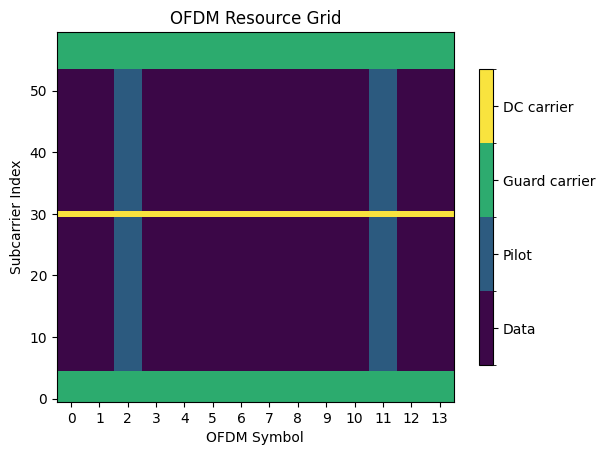

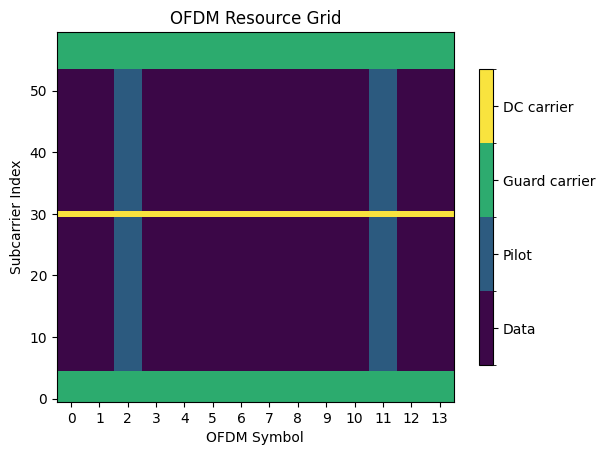

In [7]:
rg.show()

[<Figure size 640x480 with 2 Axes>, <Figure size 640x480 with 2 Axes>]

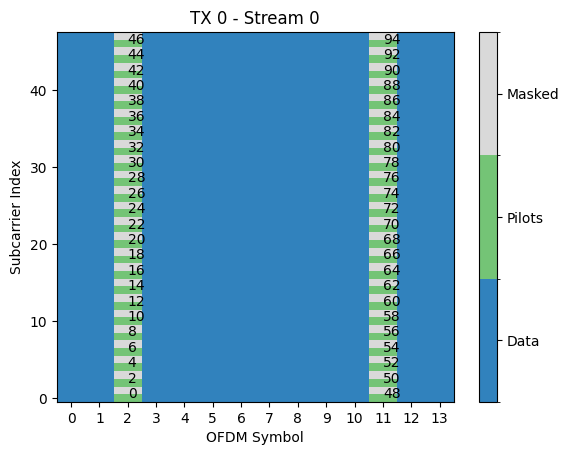

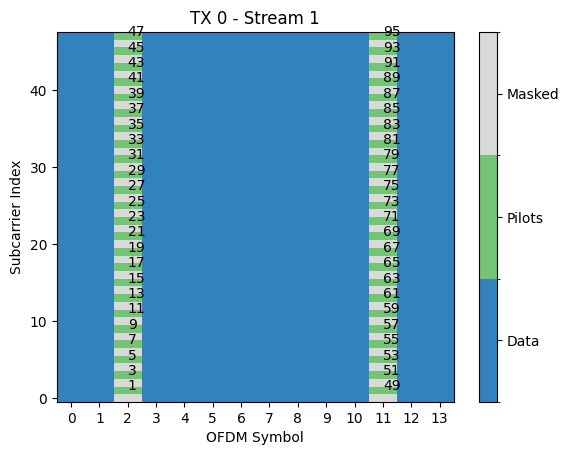

In [8]:
rg.pilot_pattern.show(show_pilot_ind=True)

Binary values: (1, 1, 2, 576)
Encoded binary values: (1, 1, 2, 1152)
QAM symbols: (1, 1, 2, 576)
Mapped QAM symbols: (1, 1, 2, 14, 60)


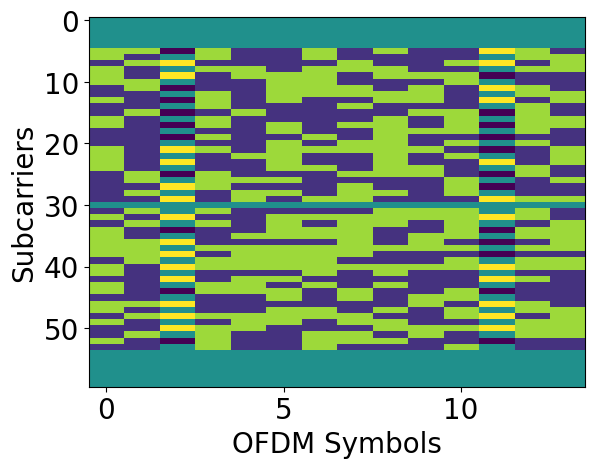

In [9]:
binary_values = binary_sources([batch_size, num_tx, num_streams_per_tx, number_of_bits])
encoded_binary_values = ldpc_encoder(binary_values)
qam_symbols = qam_mapper(encoded_binary_values)
mapped_qam_symbol = resource_grid_mapper(qam_symbols)

print(f"Binary values: {binary_values.shape}")
print(f"Encoded binary values: {encoded_binary_values.shape}")
print(f"QAM symbols: {qam_symbols.shape}")
print(f"Mapped QAM symbols: {mapped_qam_symbol.shape}")
plot_symbols(
    mapped_qam_symbol[0, 0, 0].numpy().real.T,
)

In [10]:
# modulating QAM symbols from frequency domain to time domain
modulated_qam_symbols = ofdm_modulation(mapped_qam_symbol)
modulated_qam_symbols.shape

TensorShape([1, 1, 2, 924])

Text(0, 0.5, 'Amplitude')

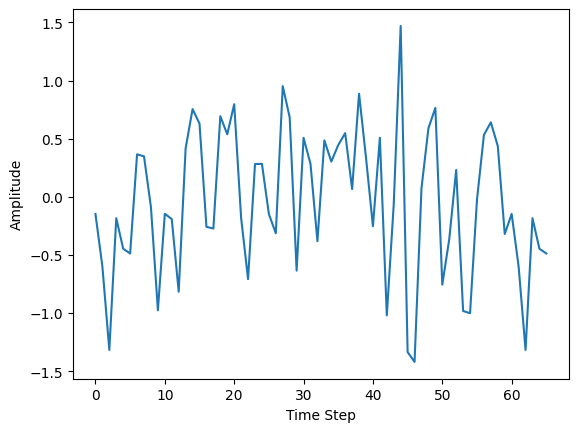

In [11]:
# Visualize results
plt.figure()
plt.plot(np.real(modulated_qam_symbols[0, 0, 0, 0:66]), "-")
plt.xlabel("Time Step")
plt.ylabel("Amplitude")

# Channel Modelling

In [12]:
cdl = CDL(
    cdl_model,
    delay_spread,
    carrier_frequency,
    ut_array,
    bs_array,
    direction,
    min_speed=speed,
)

# Noises on the channel
no = ebnodb2no(ebno_db, bits_per_symbol, code_rate, rg)

# Compute the number of time steps, and the minimum and maximum time lag
l_min, l_max = time_lag_discrete_time_channel(bandwidth)
l_tot = l_max - l_min + 1
num_time_steps = num_ofdm_symbols * (num_subcarrier + cyclic_prefix_length) + l_tot - 1
num_time_samples = num_ofdm_symbols * (num_subcarrier + cyclic_prefix_length)

# Compute the channel gain and delays on time domain
complex_gain, delay_spread = cdl(
    batch_size, num_time_steps=num_time_steps, sampling_frequency=bandwidth
)
pprint(
    {
        "Complex gain": complex_gain.shape,
        "Delay spread": delay_spread.shape,
    }
)

{'Complex gain': TensorShape([1, 1, 4, 1, 2, 23, 939]),
 'Delay spread': TensorShape([1, 1, 1, 23])}


In [13]:
pprint(
    {
        "Smallest time lag": int(l_min),
        "Largest time lag": int(l_max),
        "Number of taps": int(l_tot),
        "Number of time steps": int(num_time_steps),
        "Number of time samples": int(num_time_samples),
    }
)

{'Largest time lag': 9,
 'Number of taps': 16,
 'Number of time samples': 924,
 'Number of time steps': 939,
 'Smallest time lag': -6}


/Users/rysheng/miniconda3/envs/ele6709/lib/python3.10/site-packages/tensorflow/python/framework/ops.py:294: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())
/Users/rysheng/miniconda3/envs/ele6709/lib/python3.10/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


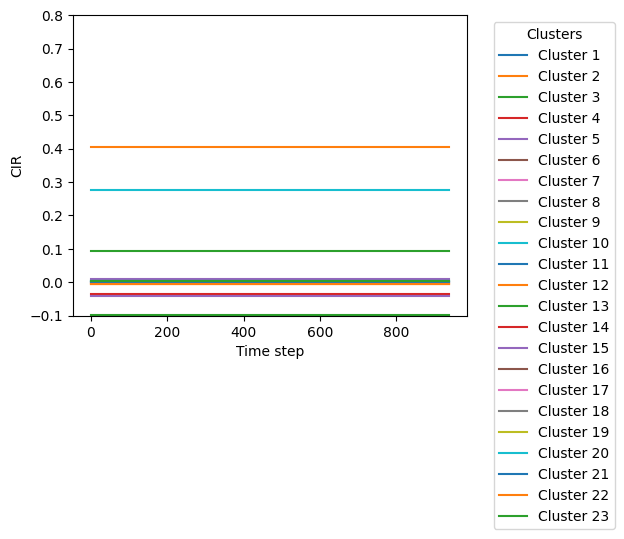

In [14]:
# Plot for each line with labels
num_lines = complex_gain[0, 0, 0, 0, 0, :, 0].shape[0]
for i in range(num_lines):
    plt.plot(complex_gain[0, 0, 0, 0, 0, i, :], label=f"Cluster {i + 1}")

plt.xlabel("Time step")
plt.ylabel("CIR")

# Scale y-axis to make the plot clearer
plt.ylim(-0.1, 0.8)  # Adjust the limits based on your data

# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Clusters")
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

Text(0, 0.5, '$|Complex Gain|$')

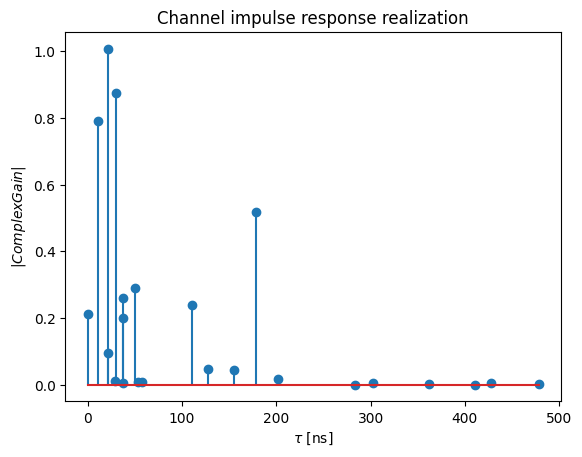

In [15]:
plt.figure()
plt.title("Channel impulse response realization")
plt.stem(delay_spread[0, 0, 0, :] / 1e-9, abs(complex_gain[0, 0, 0, 0, 0, :, 0]))
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|Complex Gain|$")

(1, 1, 4, 1, 2, 939, 16)


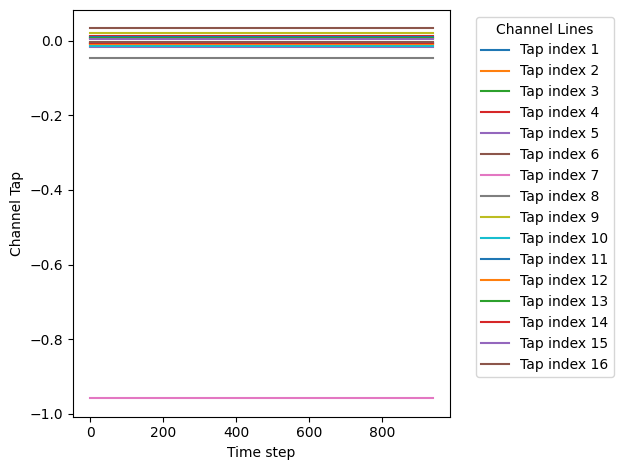

In [16]:
# h_time = channel_time_domain()
h_time = sampling_channel_time(cdl=cdl)
print(h_time.shape)

# Plot for each line with labels
num_lines = h_time[0, 0, 0, 0, 0, :, :].shape[1]
for i in range(num_lines):
    plt.plot(h_time[0, 0, 0, 0, 0, :, i], label=f"Tap index {i + 1}")

plt.xlabel("Time step")
plt.ylabel("Channel Tap")

# Scale y-axis to make the plot clearer
# plt.ylim(-0.1, 0.8)  # Adjust the limits based on your data

# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Channel Lines")
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

/Users/rysheng/miniconda3/envs/ele6709/lib/python3.10/site-packages/tensorflow/python/framework/ops.py:294: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())
/Users/rysheng/miniconda3/envs/ele6709/lib/python3.10/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


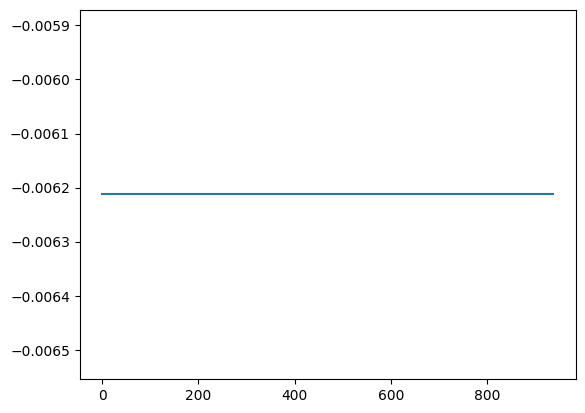

In [29]:
plt.plot(h_time[0, 0, 0, 0, 0, :, 0], label=f"Tap index {i + 1}")

Text(0, 0.5, 'Channel Tap')

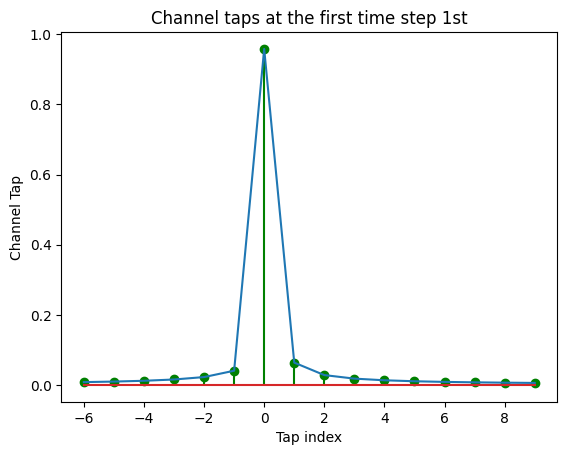

In [17]:
plt.figure()
plt.title("Channel taps at the first time step 1st")
plt.stem(np.arange(l_min, l_max + 1), abs(h_time[0, 0, 0, 0, 0, 0, :]), "green")
plt.plot(np.arange(l_min, l_max + 1), abs(h_time[0, 0, 0, 0, 0, 0, :]))
plt.xlabel("Tap index")
plt.ylabel("Channel Tap")

Text(0, 0.5, 'Subcarrier Frequency [Hz]')

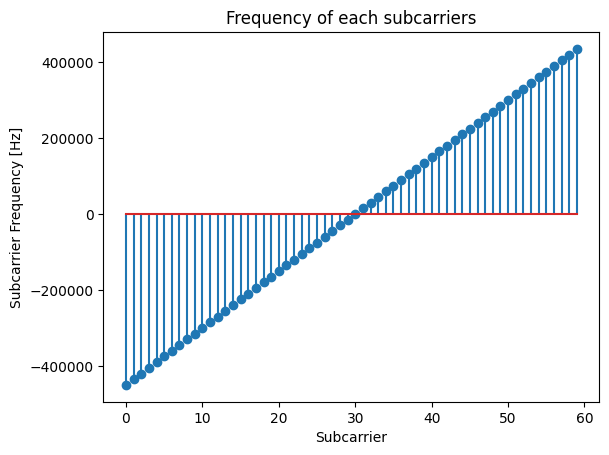

In [18]:
plt.figure()
plt.title("Frequency of each subcarriers")
plt.stem(np.arange(len(frequencies)), frequencies)
plt.xlabel("Subcarrier")
plt.ylabel("Subcarrier Frequency [Hz]")

In [19]:
frequencies

<tf.Tensor: shape=(60,), dtype=float32, numpy=
array([-450000., -435000., -420000., -405000., -390000., -375000.,
       -360000., -345000., -330000., -315000., -300000., -285000.,
       -270000., -255000., -240000., -225000., -210000., -195000.,
       -180000., -165000., -150000., -135000., -120000., -105000.,
        -90000.,  -75000.,  -60000.,  -45000.,  -30000.,  -15000.,
             0.,   15000.,   30000.,   45000.,   60000.,   75000.,
         90000.,  105000.,  120000.,  135000.,  150000.,  165000.,
        180000.,  195000.,  210000.,  225000.,  240000.,  255000.,
        270000.,  285000.,  300000.,  315000.,  330000.,  345000.,
        360000.,  375000.,  390000.,  405000.,  420000.,  435000.],
      dtype=float32)>

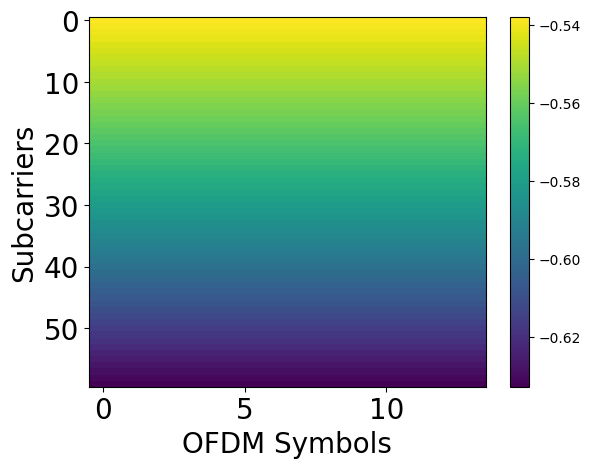

In [20]:
# h_freq = channel_frequency_domain()
h_freq = sampling_channel_freq(cdl=cdl)

# Plot for each line with labels
plot_channel_frequency_domain(
    h_freq[0, 0, 0, 0, 0].numpy().real.T,
)

# Response Modelling

In [21]:
# response signal on time domain via CDL channel model + AWGN noise
response_symbols = response_time_domain(modulated_qam_symbols, h_time)

# demodulating response signal from time domain to frequency domain
demodulated_response_symbols = ofdm_demodulation(response_symbols)

pprint(
    {
        "Response symbols": response_symbols.shape,
        "Demodulated response symbols": demodulated_response_symbols.shape,
    }
)

{'Demodulated response symbols': TensorShape([1, 1, 4, 14, 60]),
 'Response symbols': TensorShape([1, 1, 4, 939])}


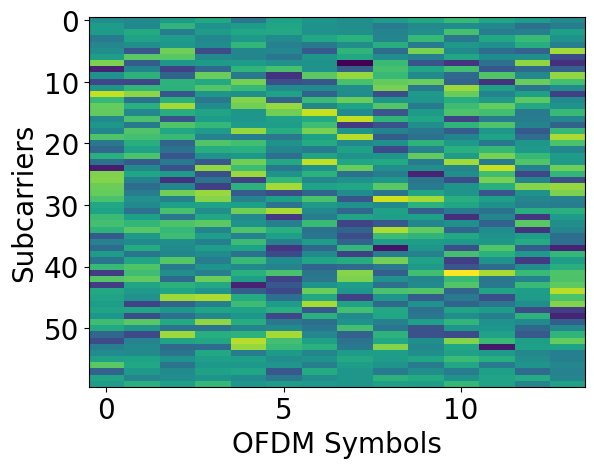

In [22]:
plot_symbols(
    demodulated_response_symbols[0, 0, 0].numpy().real.T,
)

# Evaluation Performance

In [ ]:
root_dir = ""

In [23]:
scaler = MinMaxScaler4D()


def set_up_model():
    src_dir = f"txant_{num_ut_ant}_rxant_{num_bs_ant}_speed_{speed}_samples_{number_of_samples}_ebno_0"
    h_freqs = np.load(f"{root_dir}/data/{src_dir}/h_freqs.npy")

    h_freqs = reshape_data(h_freqs)

    h_freqs = scaler.fit_transform(h_freqs)

    mu_h, std_h = compute_mean_std(h_freqs)
    mu_h = mu_h.to(device)
    std_h = std_h.to(device)

    vae = VAE(
        h_freqs.shape[1:],
        mu_h,
        std_h,
    )

    vae.load_state_dict(
        torch.load(
            f"{root_dir}/results/checkpoints/{src_dir}/vae_fold_1_best.pth",
            map_location=device,
        )["state_dict"]
    )
    vae = vae.to(device)
    vae.eval()

    return vae

In [24]:
response_matrix, h_freq = synthesys_training_data()
scaler = MinMaxScaler4D()
vae = set_up_model()

In [25]:
vae = set_up_model()
pilot_matrix = get_pilot_matrix(response_matrix)
pilot_matrix = reshape_data(pilot_matrix)
pilot_matrix = scaler.fit_transform(pilot_matrix, False).to(device)
h_est, latent_vector, encoder_output = vae(pilot_matrix)
h_est.shape

torch.Size([1, 2, 128, 64])

In [26]:
h_freq = reshape_data(h_freq.numpy())
h_freq = scaler.fit_transform(h_freq)
h_freq.shape

(1, 2, 128, 64)

In [ ]:
src_dir = f"txant_{num_ut_ant}_rxant_{num_bs_ant}_speed_{speed}_samples_{number_of_samples}_ebno_0"
h_freqs = np.load(f"{root_dir}/data/{src_dir}/h_freqs.npy")
pilot_matrices = np.load(f"{root_dir}/data/{src_dir}/pilot_matrices.npy")

In [ ]:
# vae = set_up_model()
pilot_matrix = reshape_data(pilot_matrices[40])
pilot_matrix = scaler.fit_transform(pilot_matrix, False).to(device)
h_est, latent_vector, encoder_output = vae(pilot_matrix)
h_est.shape

h_freq = reshape_data(h_freqs[40])
h_freq = scaler.fit_transform(h_freq)
h_freq.shape

(1, 2, 128, 64)

In [ ]:
import numpy as np

src_dir = f"txant_{num_ut_ant}_rxant_{num_bs_ant}_speed_{speed}_samples_{number_of_samples}_ebno_0"
h_freqs = np.load(f"{root_dir}/data/{src_dir}/h_freqs.npy")

h_freqs = reshape_data(h_freqs)

h_freqs = scaler.fit_transform(h_freqs)

mu_h, std_h = compute_mean_std(h_freqs)

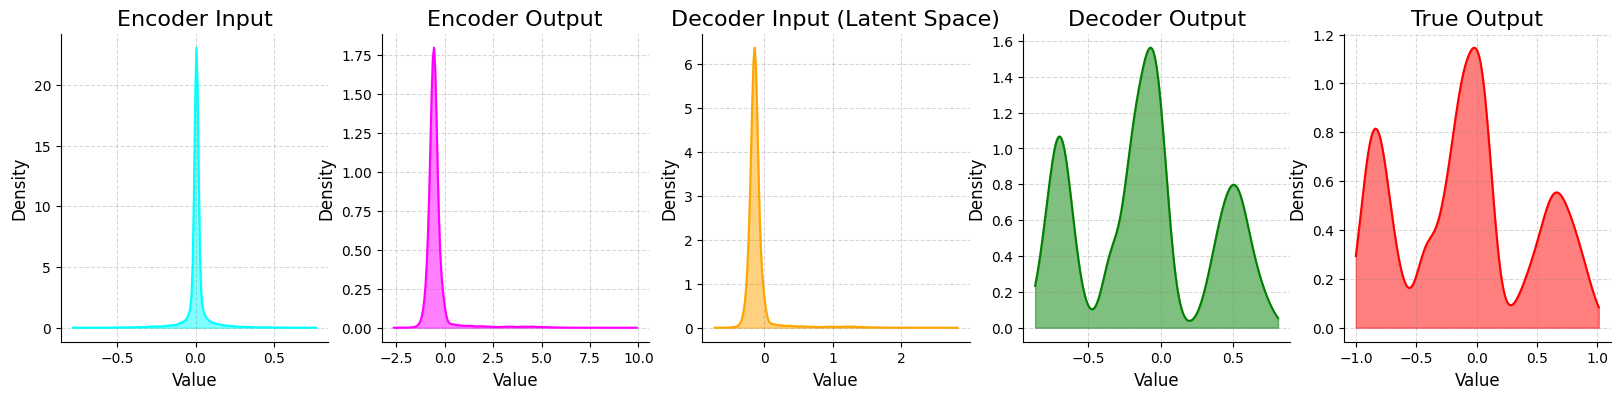

In [ ]:
plot_distribution_vae(
    pilot_matrix=pilot_matrix.detach().cpu().numpy(),
    estimated_channel=h_est.detach().cpu().numpy(),
    latent_vector=latent_vector.detach().cpu().numpy(),
    encoder_output=encoder_output.detach().cpu().numpy(),
    real_channel=h_freq,
)

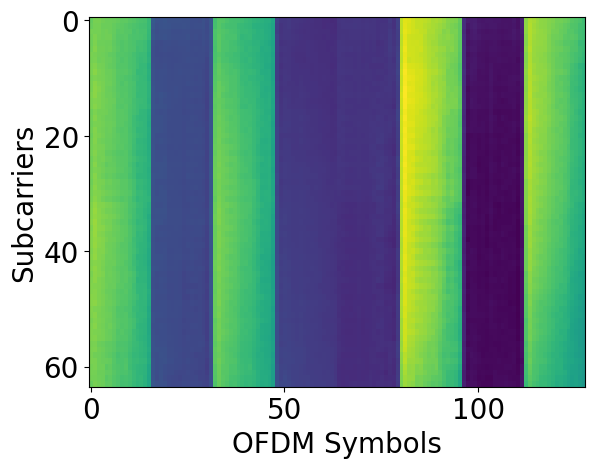

In [ ]:
plot_channel_frequency_domain(h_est[0, 0].detach().cpu().numpy().real.T)

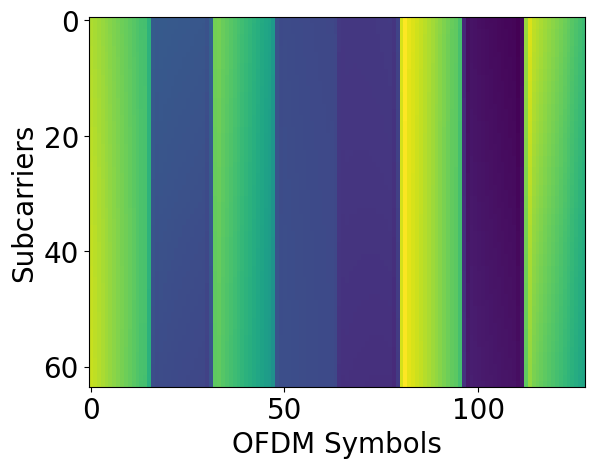

In [ ]:
plot_channel_frequency_domain(h_freq[0, 0].real.T)

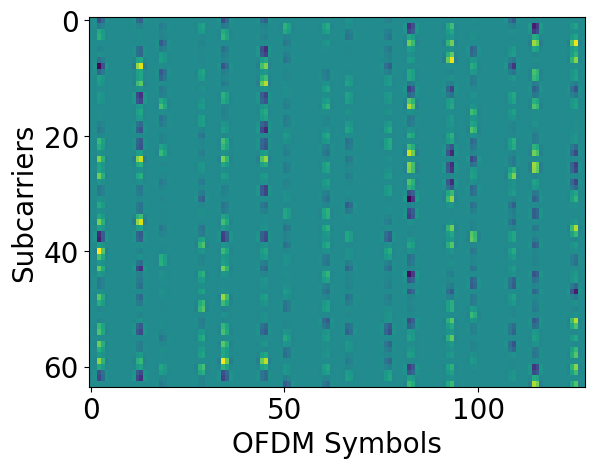

In [ ]:
plot_symbols(pilot_matrix[0, 0].detach().cpu().real.T)

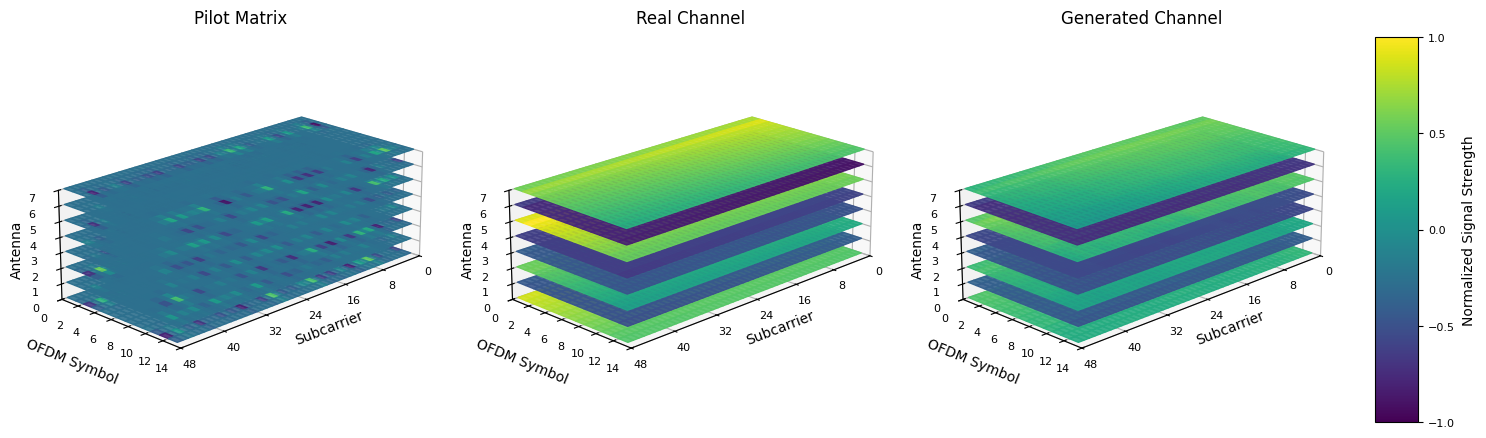

In [ ]:
from scipy.ndimage import zoom

# Zooming
zoom_factors = (1, 1, 14 * 8 / 128, 48 / 64)
reshaped_h_freq = zoom(h_freq, zoom_factors, order=1)
reshaped_h_est = zoom(h_est.detach().cpu().numpy(), zoom_factors, order=1)
reshaped_pilot_matrix = zoom(pilot_matrix.detach().cpu().numpy(), zoom_factors, order=1)

reshaped_h_freq = reversed_reshape_data(reshaped_h_freq).real
reshaped_h_est = reversed_reshape_data(reshaped_h_est).real
reshaped_pilot_matrix = reversed_reshape_data(reshaped_pilot_matrix).real

# Squeeze unnecessary dimensions to get (4, 14, 48)
reshaped_h_freq = reshaped_h_freq.squeeze()  # Shape: (4, 14, 48)
reshaped_h_est = reshaped_h_est.squeeze()  # Shape: (4, 14, 48)
reshaped_pilot_matrix = reshaped_pilot_matrix.squeeze()  # Shape: (4, 14, 48)

reshaped_h_freq = reshaped_h_freq.reshape(-1, 14, 48)
reshaped_h_est = reshaped_h_est.reshape(-1, 14, 48)
reshaped_pilot_matrix = reshaped_pilot_matrix.reshape(-1, 14, 48)

# MinMax scaling to [-1, 1]
# Compute global min and max across all three arrays
global_min = min(
    reshaped_h_freq.min(), reshaped_h_est.min(), reshaped_pilot_matrix.min()
)
global_max = max(
    reshaped_h_freq.max(), reshaped_h_est.max(), reshaped_pilot_matrix.max()
)

# Avoid division by zero if global_min == global_max
if global_max == global_min:
    reshaped_h_freq_normalized = np.zeros_like(
        reshaped_h_freq
    )  # Map to 0 if all values are identical
    reshaped_h_est_normalized = np.zeros_like(reshaped_h_est)
    reshaped_pilot_matrix_normalized = np.zeros_like(reshaped_pilot_matrix)
else:
    # Apply MinMax scaling: x_normalized = 2 * (x - min) / (max - min) - 1
    reshaped_h_freq_normalized = (
        2 * (reshaped_h_freq - global_min) / (global_max - global_min) - 1
    )
    reshaped_h_est_normalized = (
        2 * (reshaped_h_est - global_min) / (global_max - global_min) - 1
    )
    reshaped_pilot_matrix_normalized = (
        2 * (reshaped_pilot_matrix - global_min) / (global_max - global_min) - 1
    )

antennas = np.arange(8)
symbols = np.arange(14)
subcarriers = np.arange(48)

fig = plt.figure(figsize=(18, 5))  # Adjusted width for three plots
gs = fig.add_gridspec(
    1, 4, width_ratios=[1, 1, 1, 0.1], wspace=0.05
)  # Four columns: three plots, one colorbar


def plot_3d_matrix(ax, data, title):
    for i in antennas:
        X, Y = np.meshgrid(subcarriers, symbols)
        Z = np.full_like(X, i)  # Antenna index as Z-coordinate
        ax.plot_surface(
            X,
            Y,
            Z,
            rstride=1,
            cstride=1,
            facecolors=plt.cm.viridis(
                (data[i] + 1) / 2
            ),  # Map [-1, 1] to [0, 1] for viridis
            shade=False,
            alpha=0.9,  # Slightly higher alpha for solid look
        )
    ax.set_xlabel("Subcarrier", fontsize=10, labelpad=5)
    ax.set_ylabel("OFDM Symbol", fontsize=10, labelpad=5)
    # Remove default z-label and add centered text label
    # Place "Antenna" at the middle of z-axis (Z=1.5, since zlim=[0, 3])
    ax.text2D(
        -0.08,
        0.45,
        "Antenna",
        fontsize=10,
        transform=ax.transAxes,
        rotation=90,
        verticalalignment="center",
        horizontalalignment="center",
    )
    ax.set_title(title, fontsize=12, pad=10)
    # Axis limits and ticks to match the original
    ax.set_xlim(0, 48)
    ax.set_ylim(0, 14)
    ax.set_zlim(0, 7)
    ax.set_xticks(np.arange(0, 49, 8))
    ax.set_yticks(np.arange(0, 15, 2))
    ax.set_zticks(range(8))
    ax.set_box_aspect((3, 1.5, 1))  # Adjusted for taller y-axis appearance
    ax.view_init(elev=20, azim=45)  # Consistent view angle
    ax.tick_params(axis="both", which="major", labelsize=8, pad=2)
    # Reduce grid prominence
    ax.grid(True, linestyle="--", alpha=0.3)


# Plot Pilot Matrix
ax1 = fig.add_subplot(gs[0], projection="3d")
plot_3d_matrix(ax1, reshaped_pilot_matrix_normalized, "Pilot Matrix")

# Plot Real Channel
ax2 = fig.add_subplot(gs[1], projection="3d")
plot_3d_matrix(ax2, reshaped_h_freq_normalized, "Real Channel")

# Plot Generated Channel
ax3 = fig.add_subplot(gs[2], projection="3d")
plot_3d_matrix(ax3, reshaped_h_est_normalized, "Generated Channel")

# Add a shared colorbar
norm = plt.Normalize(vmin=-1, vmax=1)  # Normalized range [-1, 1]
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
cbar_ax = fig.add_subplot(gs[3])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label("Normalized Signal Strength", fontsize=10, labelpad=5)
cbar.ax.tick_params(labelsize=8)
cbar.set_ticks(np.linspace(-1, 1, 5))  # Ticks at [-1, -0.5, 0, 0.5, 1]

plt.show()

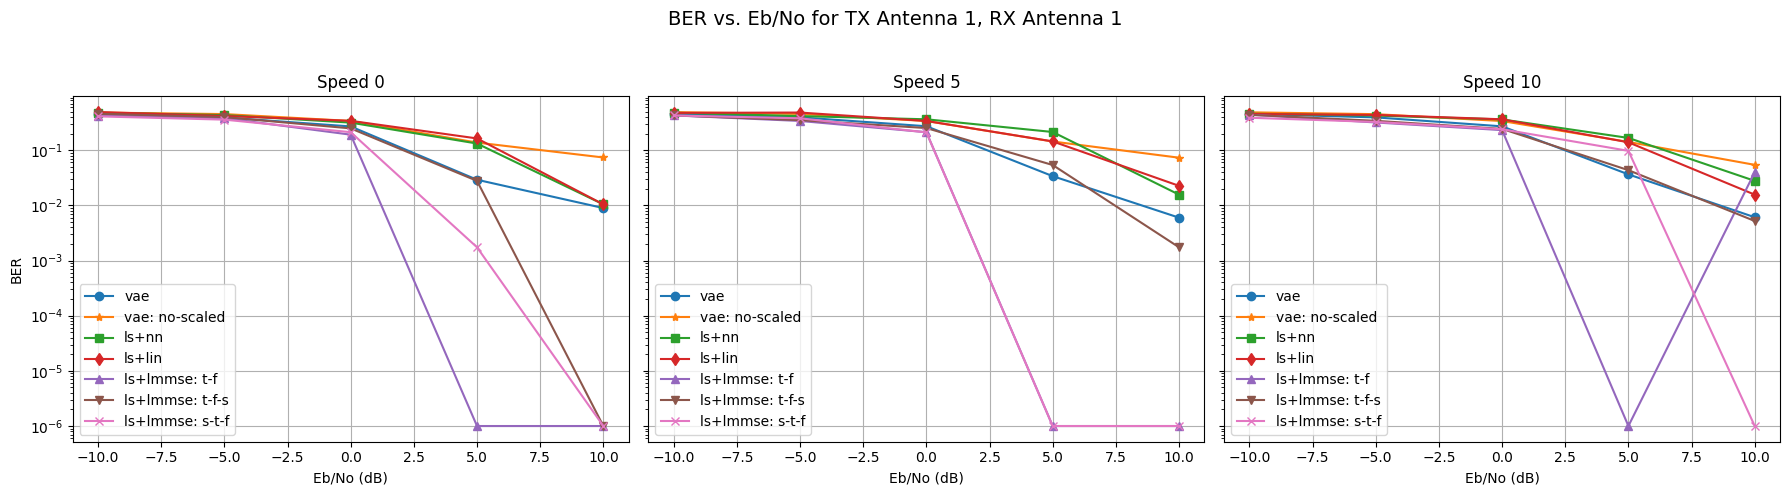

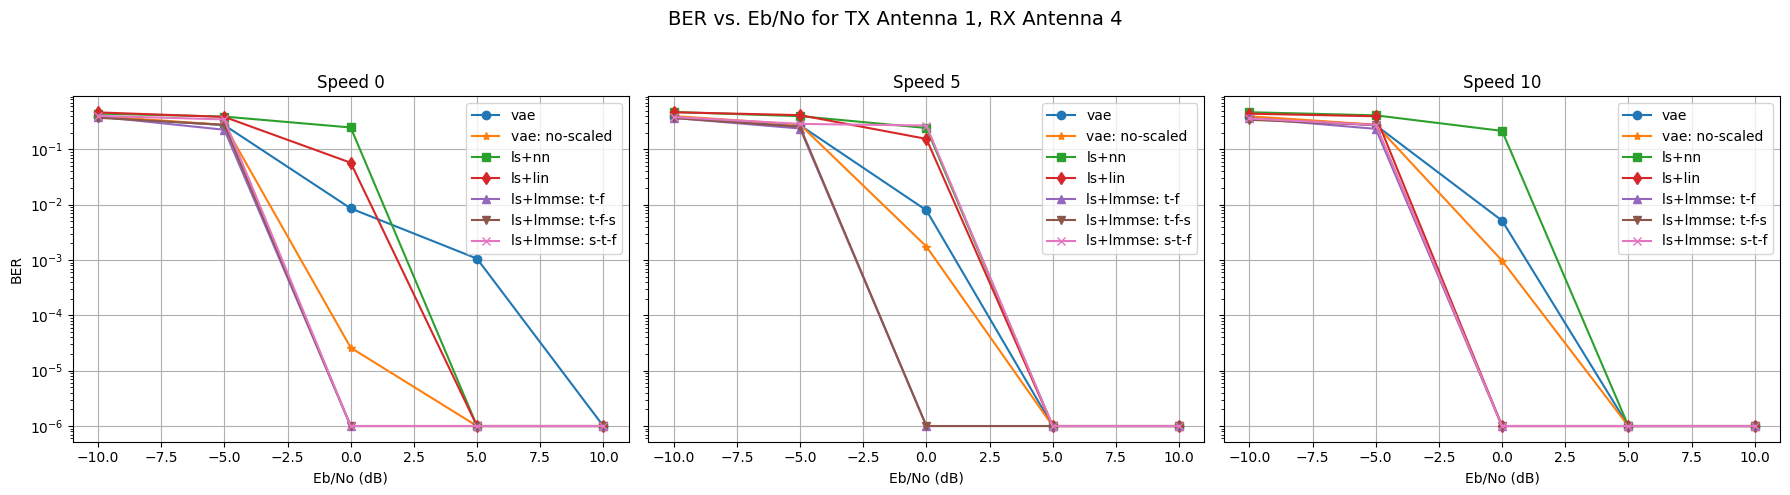

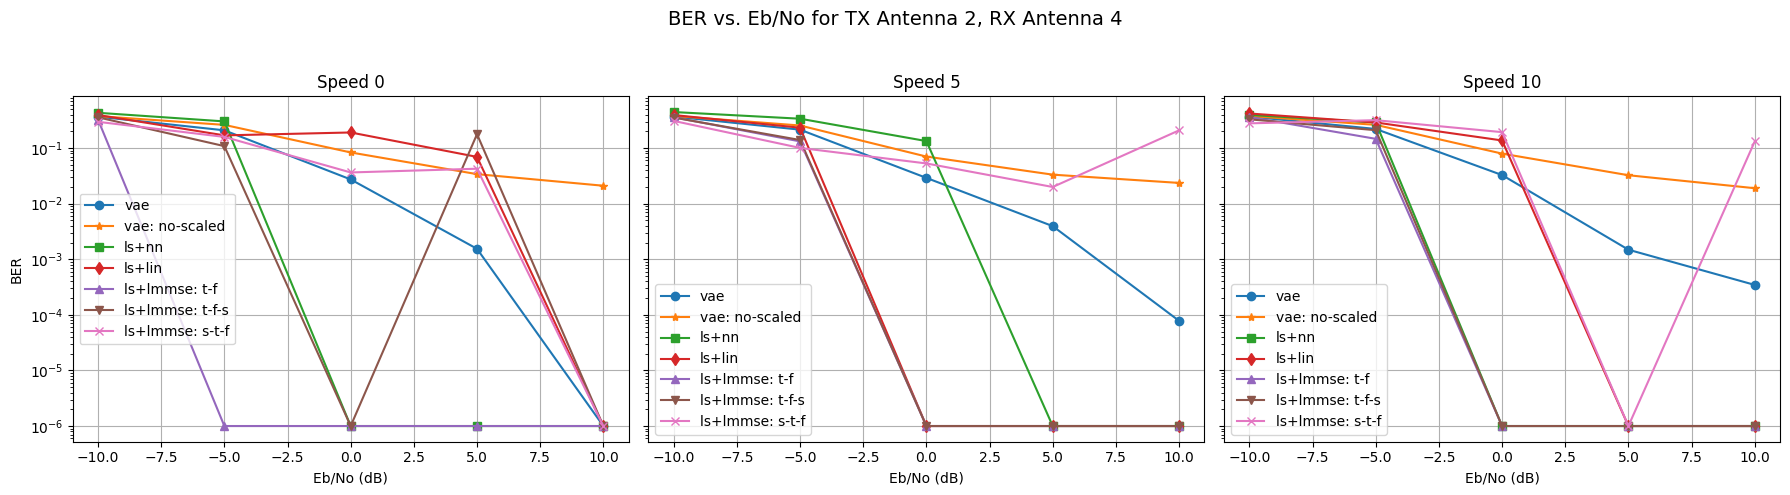

In [ ]:
import json

import matplotlib.pyplot as plt
import numpy as np

with open(f"{root_dir}/results/eval/ber/ber.json", "r") as f:
    data = json.load(f)

# Define the antenna configurations
antenna_configs = ["txant_1_rxant_1", "txant_1_rxant_4", "txant_2_rxant_4"]
titles = [
    "TX Antenna 1, RX Antenna 1",
    "TX Antenna 1, RX Antenna 4",
    "TX Antenna 2, RX Antenna 4",
]
speeds = ["0", "5", "10"]
ebno_range = range(-10, 11, 5)  # -20 to 20 dB in steps of 5
methods = [
    "vae",
    "vae: no-scaled",
    "ls+nn",
    "ls+lin",
    "ls+lmmse: t-f",
    "ls+lmmse: t-f-s",
    "ls+lmmse: s-t-f",
]
markers = [
    "o-",
    "*-",
    "s-",
    "d-",
    "^-",
    "v-",
    "x-",
]  # Different markers for each method

for j, ant_config in enumerate(antenna_configs):
    # Create a figure with 3 subplots (one per speed)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    fig.suptitle(f"BER vs. Eb/No for {titles[j]}", fontsize=14)

    for i, speed in enumerate(speeds):
        ax = axes[i]
        ebno_values = []
        ber_values = {method: [] for method in methods}

        # Collect data for this speed across all Eb/No values
        for ebno_db in ebno_range:
            key = f"speed_{speed}_ebno_db_{ebno_db}"
            if key in data[ant_config]:
                ebno_values.append(ebno_db)
                for method in methods:
                    ber_values[method].append(data[ant_config][key][method])

        # Convert to numpy arrays for easier manipulation
        ebno_values = np.array(ebno_values)
        for j, method in enumerate(methods):
            ber = np.array(ber_values[method])
            ber_plot = np.where(ber == 0, 1e-6, ber)
            ax.semilogy(ebno_values, ber_plot, markers[j], label=method)

        # Customize the subplot
        ax.set_xlabel("Eb/No (dB)")
        ax.set_ylabel("BER" if i == 0 else "")
        ax.set_title(f"Speed {speed}")
        ax.legend()
        ax.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit suptitle
    plt.show()

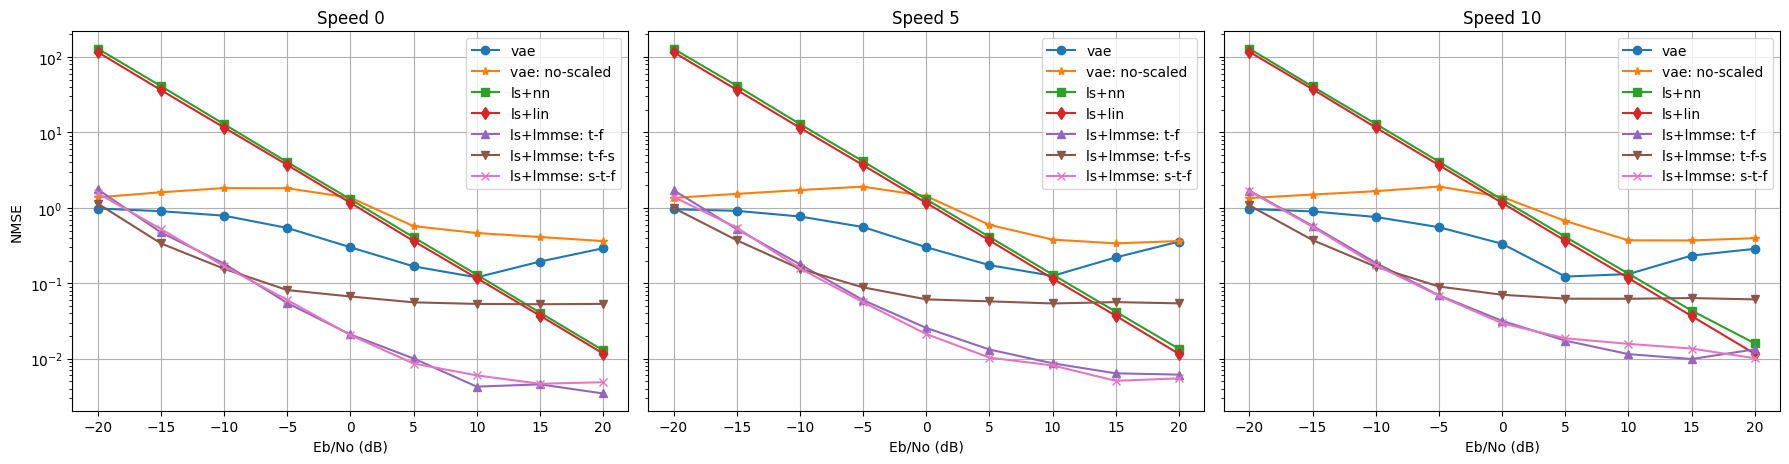

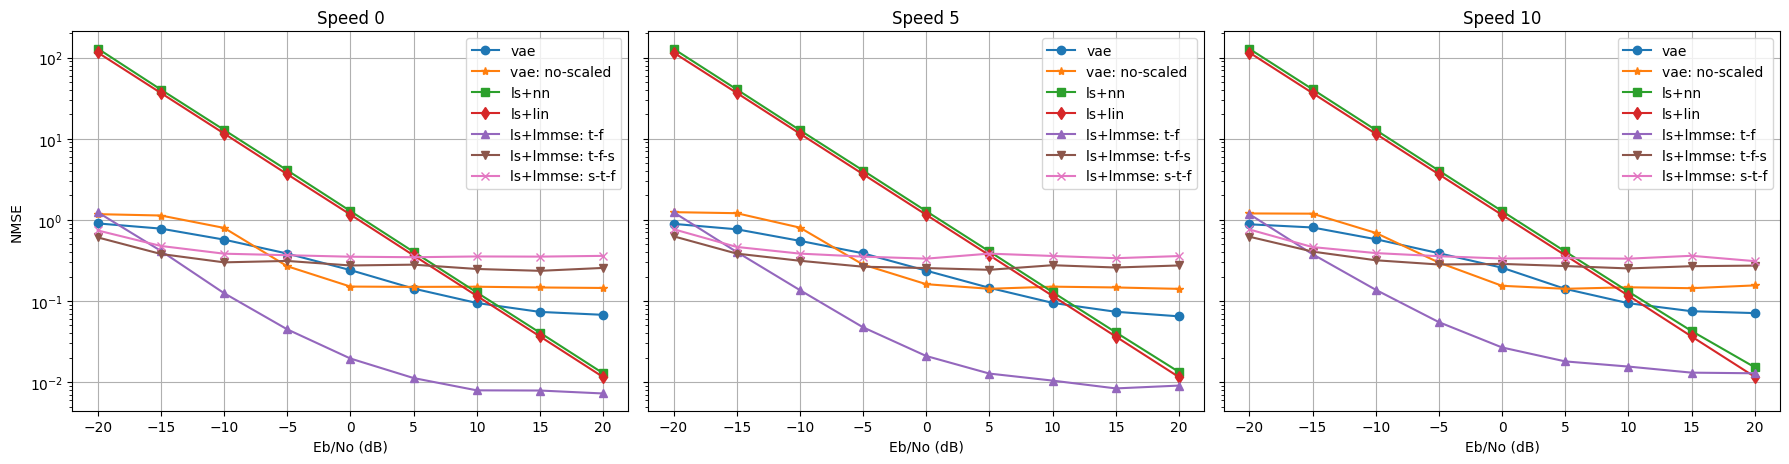

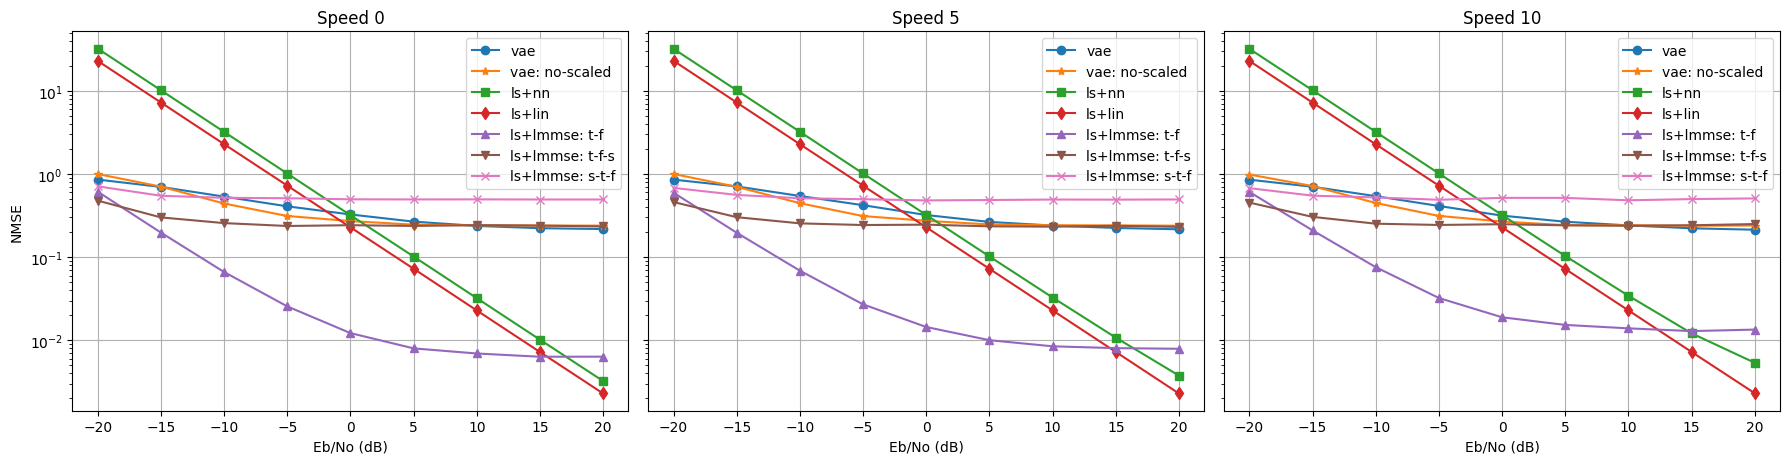

In [ ]:
# Alternatively, load from file if available
with open(f"{root_dir}/results/eval/nmse/nmse.json", "r") as f:
    data = json.load(f)

# Define the antenna configurations and titles
antenna_configs = ["txant_1_rxant_1", "txant_1_rxant_4", "txant_2_rxant_4"]
titles = [
    "TX Antenna 1, RX Antenna 1",
    "TX Antenna 1, RX Antenna 4",
    "TX Antenna 2, RX Antenna 4",
]
speeds = ["0", "5", "10"]
ebno_range = range(-20, 21, 5)  # -20 to 20 dB in steps of 5
# methods = ["vae", "ls+nn", "ls+lin", "ls+lmmse"]
# markers = ["o-", "s-", "d-", "^-"]  # Different markers for each method
methods = [
    "vae",
    "vae: no-scaled",
    "ls+nn",
    "ls+lin",
    "ls+lmmse: t-f",
    "ls+lmmse: t-f-s",
    "ls+lmmse: s-t-f",
]
markers = [
    "o-",
    "*-",
    "s-",
    "d-",
    "^-",
    "v-",
    "x-",
]  # Different markers for each method

for j, ant_config in enumerate(antenna_configs):
    # Create a figure with 3 subplots (one per speed)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    # fig.suptitle(f'NMSE vs. Eb/No for {titles[j]}', fontsize=14)

    for i, speed in enumerate(speeds):
        ax = axes[i]
        ebno_values = []
        nmse_values = {method: [] for method in methods}

        # Collect data for this speed across all Eb/No values
        for ebno_db in ebno_range:
            key = f"speed_{speed}_ebno_db_{ebno_db}"
            if key in data[ant_config]:
                ebno_values.append(ebno_db)
                for method in methods:
                    nmse_values[method].append(data[ant_config][key][method])

        # Convert to numpy arrays for easier manipulation
        ebno_values = np.array(ebno_values)
        for k, method in enumerate(methods):
            nmse = np.array(nmse_values[method])
            ax.semilogy(ebno_values, nmse, markers[k], label=method)

        # Customize the subplot
        ax.set_xlabel("Eb/No (dB)")
        ax.set_ylabel("NMSE" if i == 0 else "")
        ax.set_title(f"Speed {speed}")
        ax.legend()
        ax.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit suptitle
    plt.show()

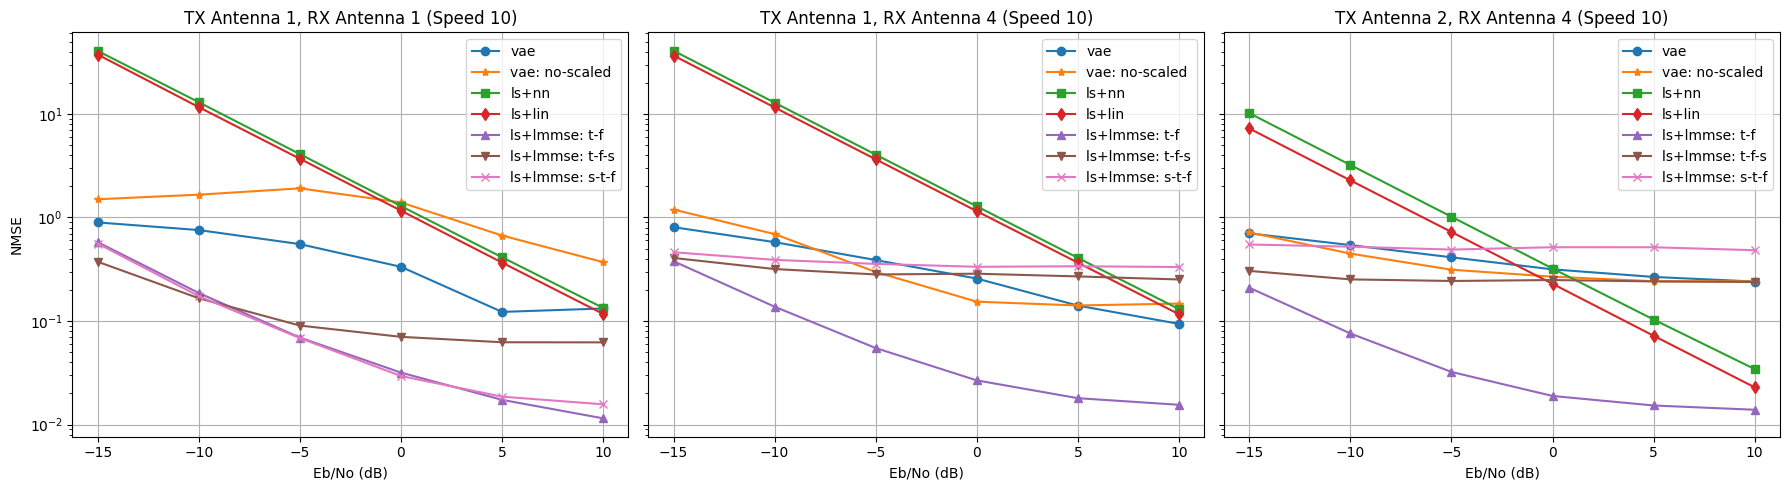

In [ ]:
# Load data
with open(f"{root_dir}/results/eval/nmse/nmse.json", "r") as f:
    data = json.load(f)

# Antenna configurations and corresponding titles
antenna_configs = ["txant_1_rxant_1", "txant_1_rxant_4", "txant_2_rxant_4"]
titles = [
    "TX Antenna 1, RX Antenna 1",
    "TX Antenna 1, RX Antenna 4",
    "TX Antenna 2, RX Antenna 4",
]

# Fixed speed
speed = "10"
ebno_range = range(-15, 15, 5)

# Methods and line markers
methods = [
    "vae",
    "vae: no-scaled",
    "ls+nn",
    "ls+lin",
    "ls+lmmse: t-f",
    "ls+lmmse: t-f-s",
    "ls+lmmse: s-t-f",
]
markers = ["o-", "*-", "s-", "d-", "^-", "v-", "x-"]

# Create a 1-row, 3-column figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for j, (ant_config, ax) in enumerate(zip(antenna_configs, axes)):
    ebno_values = []
    nmse_values = {method: [] for method in methods}

    # Collect data for speed = 10
    for ebno_db in ebno_range:
        key = f"speed_{speed}_ebno_db_{ebno_db}"
        if key in data[ant_config]:
            ebno_values.append(ebno_db)
            for method in methods:
                nmse_values[method].append(data[ant_config][key][method])

    ebno_values = np.array(ebno_values)
    for k, method in enumerate(methods):
        nmse = np.array(nmse_values[method])
        ax.semilogy(ebno_values, nmse, markers[k], label=method)

    ax.set_title(f"{titles[j]} (Speed {speed})")
    ax.set_xlabel("Eb/No (dB)")
    if j == 0:
        ax.set_ylabel("NMSE")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

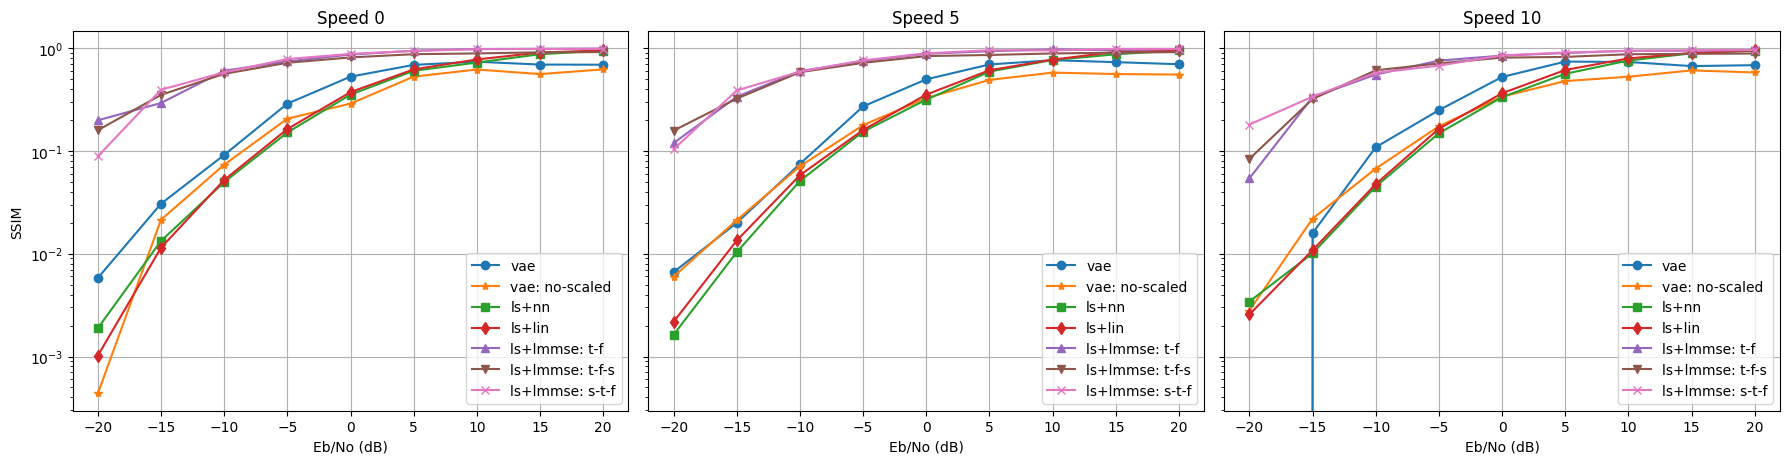

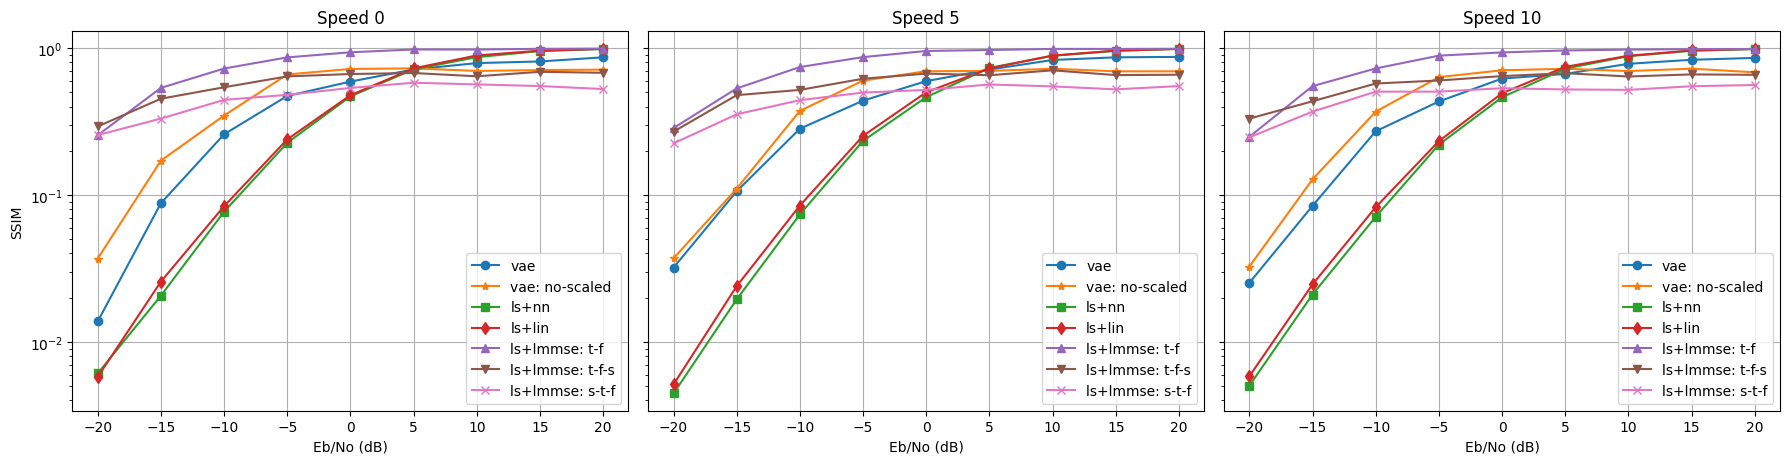

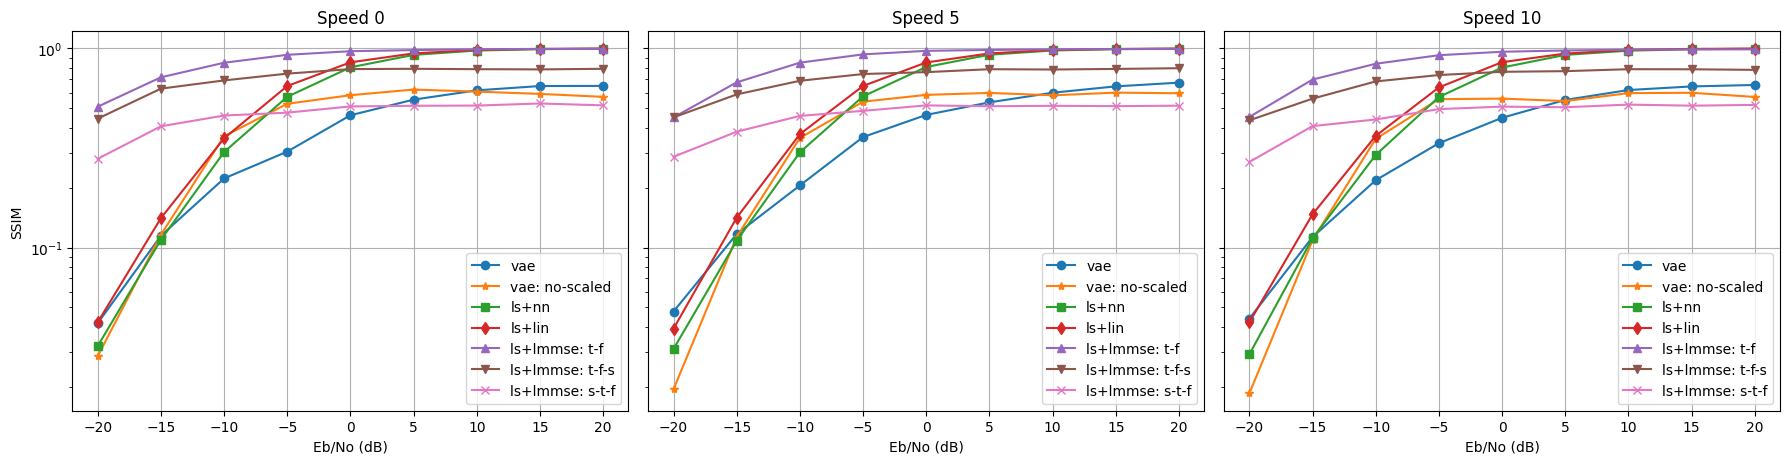

In [ ]:
# Alternatively, load from file if available
with open(f"{root_dir}/results/eval/ssim/ssim.json", "r") as f:
    data = json.load(f)

# Define the antenna configurations and titles
antenna_configs = ["txant_1_rxant_1", "txant_1_rxant_4", "txant_2_rxant_4"]
titles = [
    "TX Antenna 1, RX Antenna 1",
    "TX Antenna 1, RX Antenna 4",
    "TX Antenna 2, RX Antenna 4",
]
speeds = ["0", "5", "10"]
ebno_range = range(-20, 21, 5)  # -20 to 20 dB in steps of 5
# methods = ["vae", "ls+nn", "ls+lin", "ls+lmmse"]
# markers = ["o-", "s-", "d-", "^-"]  # Different markers for each method
methods = [
    "vae",
    "vae: no-scaled",
    "ls+nn",
    "ls+lin",
    "ls+lmmse: t-f",
    "ls+lmmse: t-f-s",
    "ls+lmmse: s-t-f",
]
markers = [
    "o-",
    "*-",
    "s-",
    "d-",
    "^-",
    "v-",
    "x-",
]  # Different markers for each method

for j, ant_config in enumerate(antenna_configs):
    # Create a figure with 3 subplots (one per speed)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    # fig.suptitle(f'NMSE vs. Eb/No for {titles[j]}', fontsize=14)

    for i, speed in enumerate(speeds):
        ax = axes[i]
        ebno_values = []
        ssim_values = {method: [] for method in methods}

        # Collect data for this speed across all Eb/No values
        for ebno_db in ebno_range:
            key = f"speed_{speed}_ebno_db_{ebno_db}"
            if key in data[ant_config]:
                ebno_values.append(ebno_db)
                for method in methods:
                    ssim_values[method].append(data[ant_config][key][method])

        # Convert to numpy arrays for easier manipulation
        ebno_values = np.array(ebno_values)
        for k, method in enumerate(methods):
            nmse = np.array(ssim_values[method])
            ax.semilogy(ebno_values, nmse, markers[k], label=method)

        # Customize the subplot
        ax.set_xlabel("Eb/No (dB)")
        ax.set_ylabel("SSIM" if i == 0 else "")
        ax.set_title(f"Speed {speed}")
        ax.legend()
        ax.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit suptitle
    plt.show()

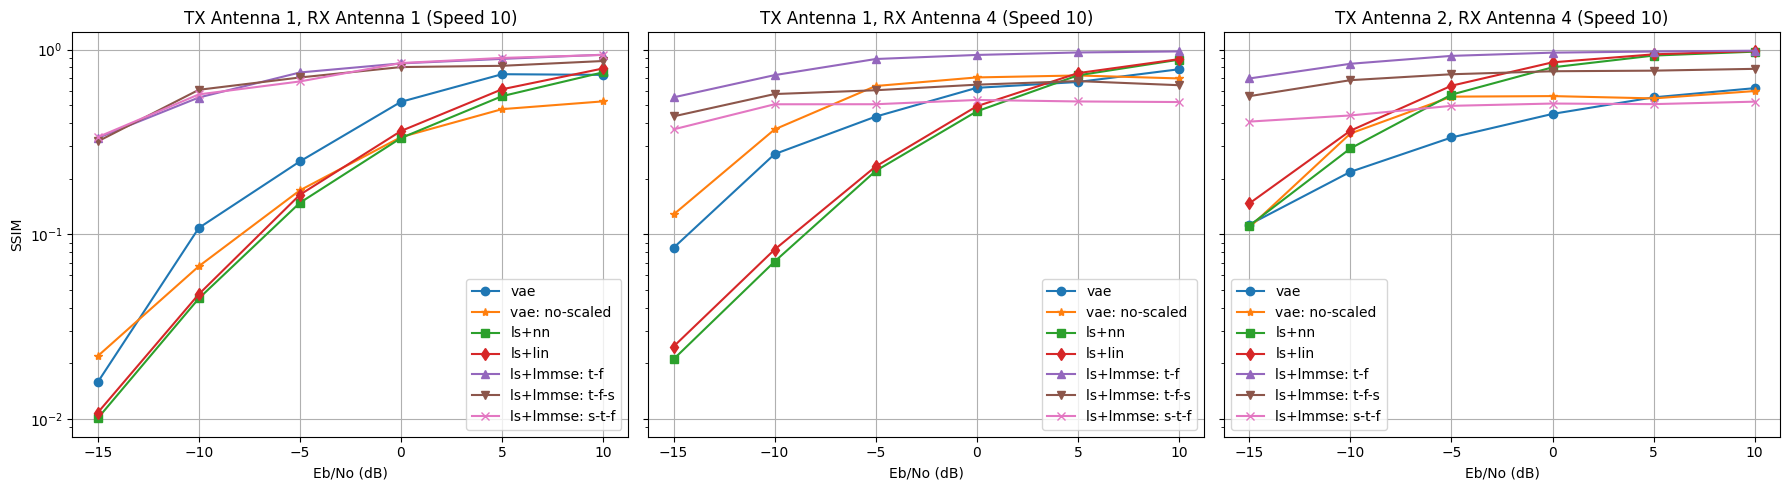

In [ ]:
# Load data
with open(f"{root_dir}/results/eval/ssim/ssim.json", "r") as f:
    data = json.load(f)

# Antenna configurations and corresponding titles
antenna_configs = ["txant_1_rxant_1", "txant_1_rxant_4", "txant_2_rxant_4"]
titles = [
    "TX Antenna 1, RX Antenna 1",
    "TX Antenna 1, RX Antenna 4",
    "TX Antenna 2, RX Antenna 4",
]

# Fixed speed
speed = "10"
ebno_range = range(-15, 15, 5)

# Methods and line markers
methods = [
    "vae",
    "vae: no-scaled",
    "ls+nn",
    "ls+lin",
    "ls+lmmse: t-f",
    "ls+lmmse: t-f-s",
    "ls+lmmse: s-t-f",
]
markers = ["o-", "*-", "s-", "d-", "^-", "v-", "x-"]

# Create a 1-row, 3-column figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for j, (ant_config, ax) in enumerate(zip(antenna_configs, axes)):
    ebno_values = []
    ssim_values = {method: [] for method in methods}

    # Collect data for speed = 10
    for ebno_db in ebno_range:
        key = f"speed_{speed}_ebno_db_{ebno_db}"
        if key in data[ant_config]:
            ebno_values.append(ebno_db)
            for method in methods:
                ssim_values[method].append(data[ant_config][key][method])

    ebno_values = np.array(ebno_values)
    for k, method in enumerate(methods):
        nmse = np.array(ssim_values[method])
        ax.semilogy(ebno_values, nmse, markers[k], label=method)

    ax.set_title(f"{titles[j]} (Speed {speed})")
    ax.set_xlabel("Eb/No (dB)")
    if j == 0:
        ax.set_ylabel("SSIM")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
with open(f"{root_dir}/results/eval/ber/ber.json", "r") as f:
    data = json.load(f)


# Define the parameters
antenna_configs = ["txant_2_rxant_4"]
speeds = ["10"]
ebno_range = range(-20, 21, 5)  # -20 to 20 dB in steps of 5
methods = [
    "vae",
    "vae: no-scaled",
    "ls+nn",
    "ls+lin",
    "ls+lmmse: t-f",
    "ls+lmmse: t-f-s",
    "ls+lmmse: s-t-f",
]

# Initialize lists to store table data
rows = []

# Iterate through all combinations
for ant_config in antenna_configs:
    for speed in speeds:
        for ebno_db in ebno_range:
            key = f"speed_{speed}_ebno_db_{ebno_db}"
            if key in data[ant_config]:
                # Extract BER values for all methods
                ber_values = data[ant_config][key]
                # Replace BER = 0 with 1e-6
                row = {"Antenna_Config": ant_config, "Speed": speed, "EbNo_dB": ebno_db}
                for method in methods:
                    ber = ber_values[method]
                    row[method] = ber
                rows.append(row)

# Create a pandas DataFrame
df = pd.DataFrame(rows)

# Reorder columns for clarity
df = df[
    [
        "Antenna_Config",
        "Speed",
        "EbNo_dB",
        "vae",
        "vae: no-scaled",
        "ls+nn",
        "ls+lin",
        "ls+lmmse: t-f",
        "ls+lmmse: t-f-s",
        "ls+lmmse: s-t-f",
    ]
]

# Save the DataFrame to a CSV file
df.to_csv(f"{root_dir}/results/eval/ber/ber.csv", index=False)

Average Runtimes (seconds):
                       vae  vae: no-scaled     ls+nn    ls+lin  ls+lmmse: t-f  \
txant_1_rxant_1  0.262072        0.260090  0.267412  0.267666       0.480686   
txant_1_rxant_4  0.265438        0.267566  0.270436  0.271004       0.493368   
txant_2_rxant_4  0.275814        0.279604  0.285634  0.283158       0.660084   

                 ls+lmmse: t-f-s  ls+lmmse: s-t-f  
txant_1_rxant_1         0.485402         0.483989  
txant_1_rxant_4         0.505379         0.504601  
txant_2_rxant_4         0.668199         0.664064  


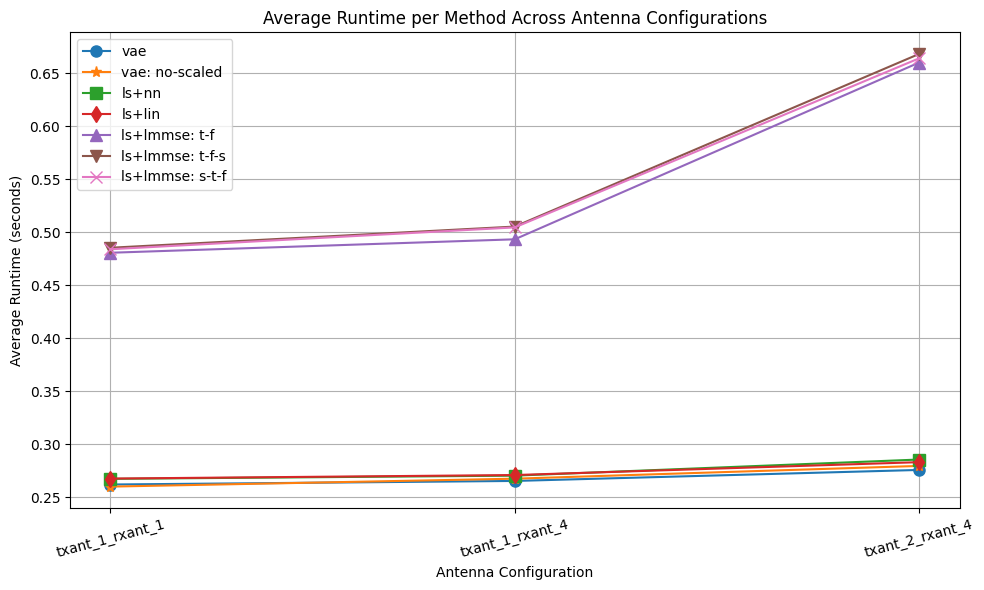

In [ ]:
# Load the JSON data from time.json
with open(f"{root_dir}/results/eval/ber/time.json", "r") as f:
    data = json.load(f)

# Define the parameters
antenna_configs = ["txant_1_rxant_1", "txant_1_rxant_4", "txant_2_rxant_4"]
speeds = ["0", "5", "10"]
ebno_range = range(-20, 21, 5)  # -20 to 20 dB in steps of 5
methods = [
    "vae",
    "vae: no-scaled",
    "ls+nn",
    "ls+lin",
    "ls+lmmse: t-f",
    "ls+lmmse: t-f-s",
    "ls+lmmse: s-t-f",
]
markers = [
    "o-",
    "*-",
    "s-",
    "d-",
    "^-",
    "v-",
    "x-",
]  # Different markers for each method

# Initialize a dictionary to store average runtimes
avg_runtimes = {method: [] for method in methods}

# Compute average runtime for each antenna config and method
for ant_config in antenna_configs:
    for method in methods:
        runtimes = []
        # Collect runtimes across all speeds and Eb/No values
        for speed in speeds:
            for ebno_db in ebno_range:
                key = f"speed_{speed}_ebno_db_{ebno_db}"
                if key in data[ant_config]:
                    runtime = data[ant_config][key][method]
                    runtimes.append(runtime)
        # Compute the average
        avg_runtime = np.mean(runtimes) if runtimes else np.nan
        avg_runtimes[method].append(avg_runtime)

# Create a DataFrame for the average runtimes (for reference)
df_avg = pd.DataFrame(avg_runtimes, index=antenna_configs)
print("Average Runtimes (seconds):\n", df_avg)

# Plot the average runtimes
plt.figure(figsize=(10, 6))
for i, method in enumerate(methods):
    plt.plot(
        antenna_configs, avg_runtimes[method], markers[i], label=method, markersize=8
    )

# Customize the plot
plt.xlabel("Antenna Configuration")
plt.ylabel("Average Runtime (seconds)")
plt.title("Average Runtime per Method Across Antenna Configurations")
plt.grid(True)
plt.legend()
plt.xticks(rotation=15)  # Rotate x-axis labels for readability

# Save the plot
plt.tight_layout()

Average Runtimes (seconds):
                       vae  vae: no-scaled     ls+nn    ls+lin  ls+lmmse: t-f  \
txant_1_rxant_1  0.044927        0.044924  0.051545  0.051613       0.264010   
txant_1_rxant_4  0.050129        0.049530  0.055889  0.056657       0.283338   
txant_2_rxant_4  0.051953        0.053401  0.063141  0.059365       0.432144   

                 ls+lmmse: t-f-s  ls+lmmse: s-t-f  
txant_1_rxant_1         0.269139         0.267366  
txant_1_rxant_4         0.291141         0.289193  
txant_2_rxant_4         0.437496         0.437553  


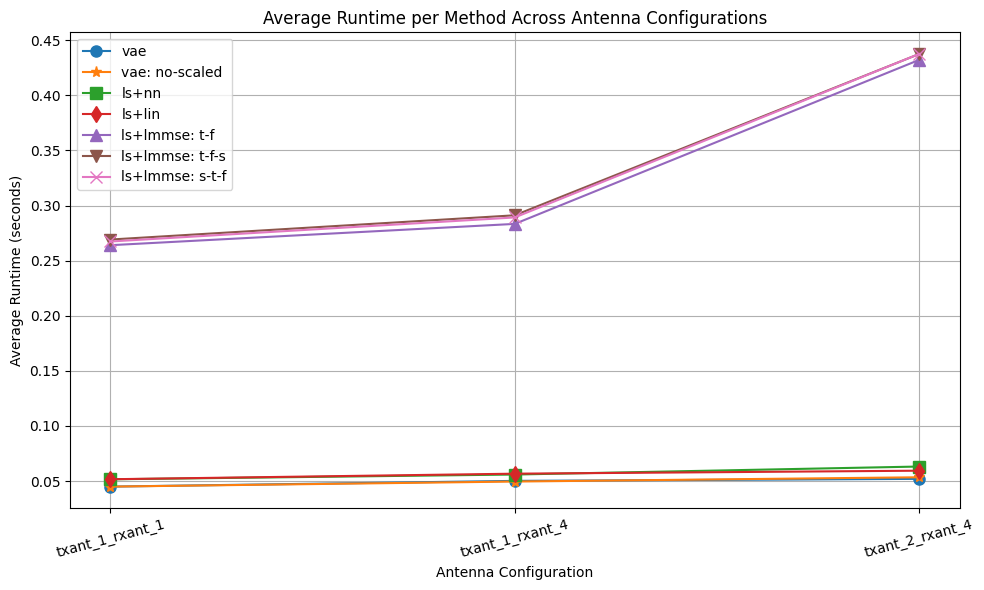

In [ ]:
# Load the JSON data from time.json
with open(f"{root_dir}/results/eval/nmse/time.json", "r") as f:
    data = json.load(f)

# Define the parameters
antenna_configs = ["txant_1_rxant_1", "txant_1_rxant_4", "txant_2_rxant_4"]
speeds = ["0", "5", "10"]
ebno_range = range(-20, 21, 5)  # -20 to 20 dB in steps of 5
methods = [
    "vae",
    "vae: no-scaled",
    "ls+nn",
    "ls+lin",
    "ls+lmmse: t-f",
    "ls+lmmse: t-f-s",
    "ls+lmmse: s-t-f",
]
markers = [
    "o-",
    "*-",
    "s-",
    "d-",
    "^-",
    "v-",
    "x-",
]  # Different markers for each method

# Initialize a dictionary to store average runtimes
avg_runtimes = {method: [] for method in methods}

# Compute average runtime for each antenna config and method
for ant_config in antenna_configs:
    for method in methods:
        runtimes = []
        # Collect runtimes across all speeds and Eb/No values
        for speed in speeds:
            for ebno_db in ebno_range:
                key = f"speed_{speed}_ebno_db_{ebno_db}"
                if key in data[ant_config]:
                    runtime = data[ant_config][key][method]
                    runtimes.append(runtime)
        # Compute the average
        avg_runtime = np.mean(runtimes) if runtimes else np.nan
        avg_runtimes[method].append(avg_runtime)

# Create a DataFrame for the average runtimes (for reference)
df_avg = pd.DataFrame(avg_runtimes, index=antenna_configs)
print("Average Runtimes (seconds):\n", df_avg)

# Plot the average runtimes
plt.figure(figsize=(10, 6))
for i, method in enumerate(methods):
    plt.plot(
        antenna_configs, avg_runtimes[method], markers[i], label=method, markersize=8
    )

# Customize the plot
plt.xlabel("Antenna Configuration")
plt.ylabel("Average Runtime (seconds)")
plt.title("Average Runtime per Method Across Antenna Configurations")
plt.grid(True)
plt.legend()
plt.xticks(rotation=15)  # Rotate x-axis labels for readability

# Save the plot
plt.tight_layout()

['txant_2_rxant_4_with_5_rays', 'txant_2_rxant_4_with_8_clusters', 'txant_2_rxant_4_with_50_vels', 'txant_2_rxant_4_base_line']


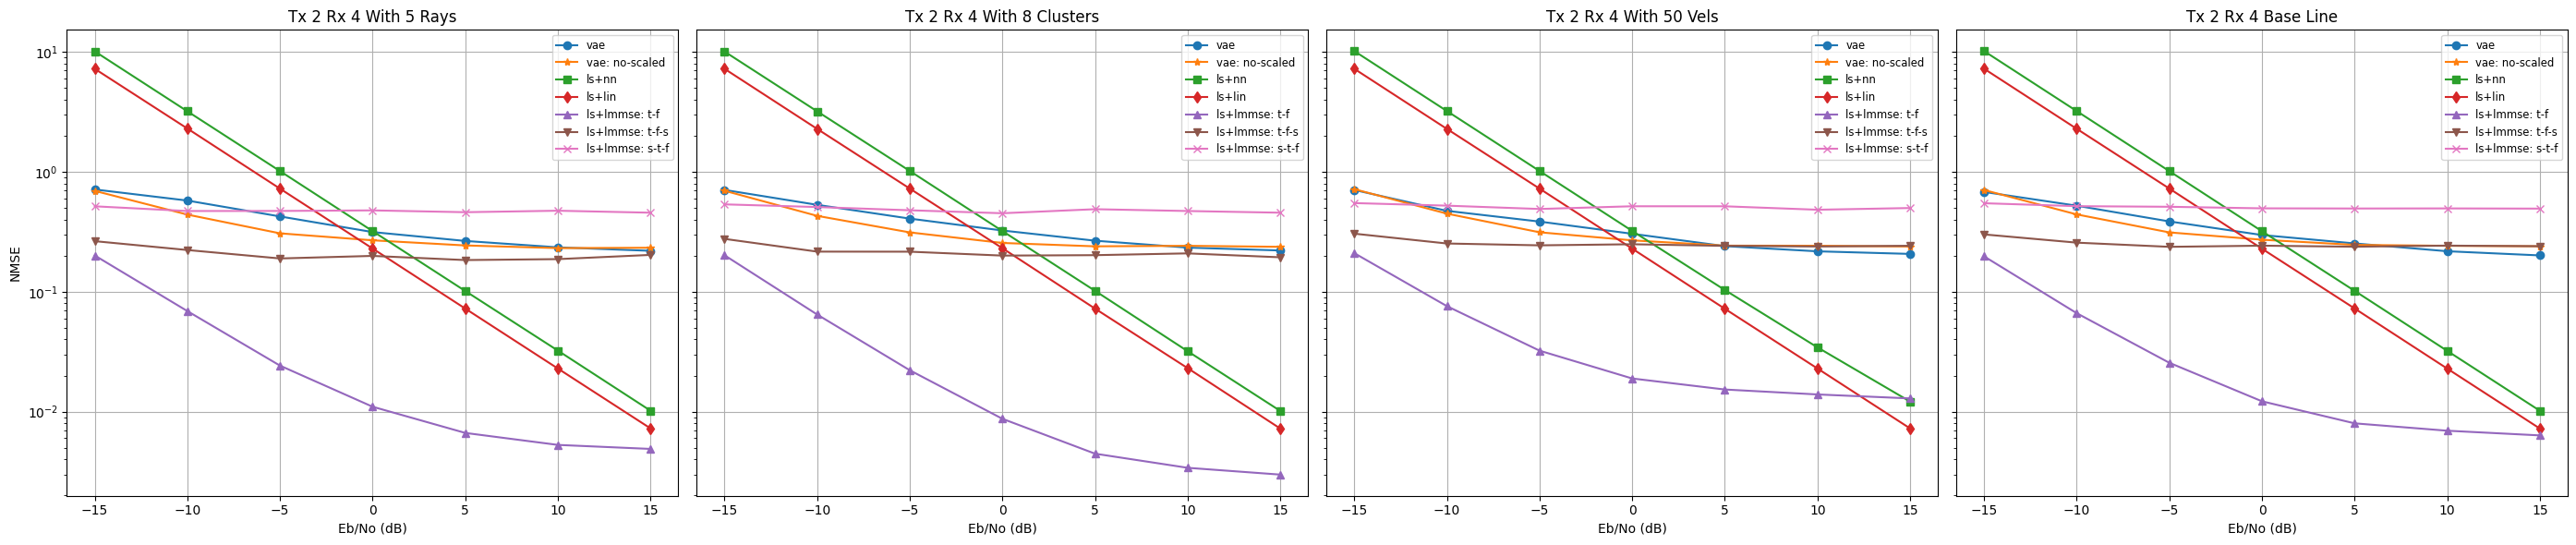

In [16]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON data from time.json
with open(f"{root_dir}/eval/nmse.json", "r") as f:
    data = json.load(f)


# Antenna configs and their display titles
antenna_configs = list(data.keys())
print(antenna_configs)
titles = [
    cfg.replace("_", " ")
    .replace("txant", "TX")
    .replace("rxant", "RX")
    .replace("with", "with")
    .title()
    for cfg in antenna_configs
]

# Define Eb/No range
ebno_range = list(range(-15, 20, 5))

# Methods and plot markers
methods = [
    "vae",
    "vae: no-scaled",
    "ls+nn",
    "ls+lin",
    "ls+lmmse: t-f",
    "ls+lmmse: t-f-s",
    "ls+lmmse: s-t-f",
]
markers = ["o-", "*-", "s-", "d-", "^-", "v-", "x-"]

# Create 1-row, 4-column plot
fig, axes = plt.subplots(1, 4, figsize=(28, 6), sharey=True)

for j, (ant_config, ax) in enumerate(zip(antenna_configs, axes)):
    # Speed is 50 only for '50_vels', otherwise 0
    speed = "50" if "50_vels" in ant_config else "0"

    ebno_values = []
    nmse_values = {method: [] for method in methods}

    # Loop through SNR values
    for ebno_db in ebno_range:
        key = f"speed_{speed}_ebno_db_{ebno_db}"
        if key in data[ant_config]:
            ebno_values.append(ebno_db)
            for method in methods:
                nmse_values[method].append(data[ant_config][key][method])

    ebno_values = np.array(ebno_values)

    # Plot each method
    for k, method in enumerate(methods):
        nmse = np.array(nmse_values[method])
        ax.semilogy(ebno_values, nmse, markers[k], label=method)

    ax.set_title(f"{titles[j]}")
    ax.set_xlabel("Eb/No (dB)")
    if j == 0:
        ax.set_ylabel("NMSE")
    ax.grid(True)
    ax.legend(fontsize="small")

plt.tight_layout()
plt.show()

['txant_2_rxant_4_with_5_rays', 'txant_2_rxant_4_with_8_clusters', 'txant_2_rxant_4_with_50_vels', 'txant_2_rxant_4_base_line']


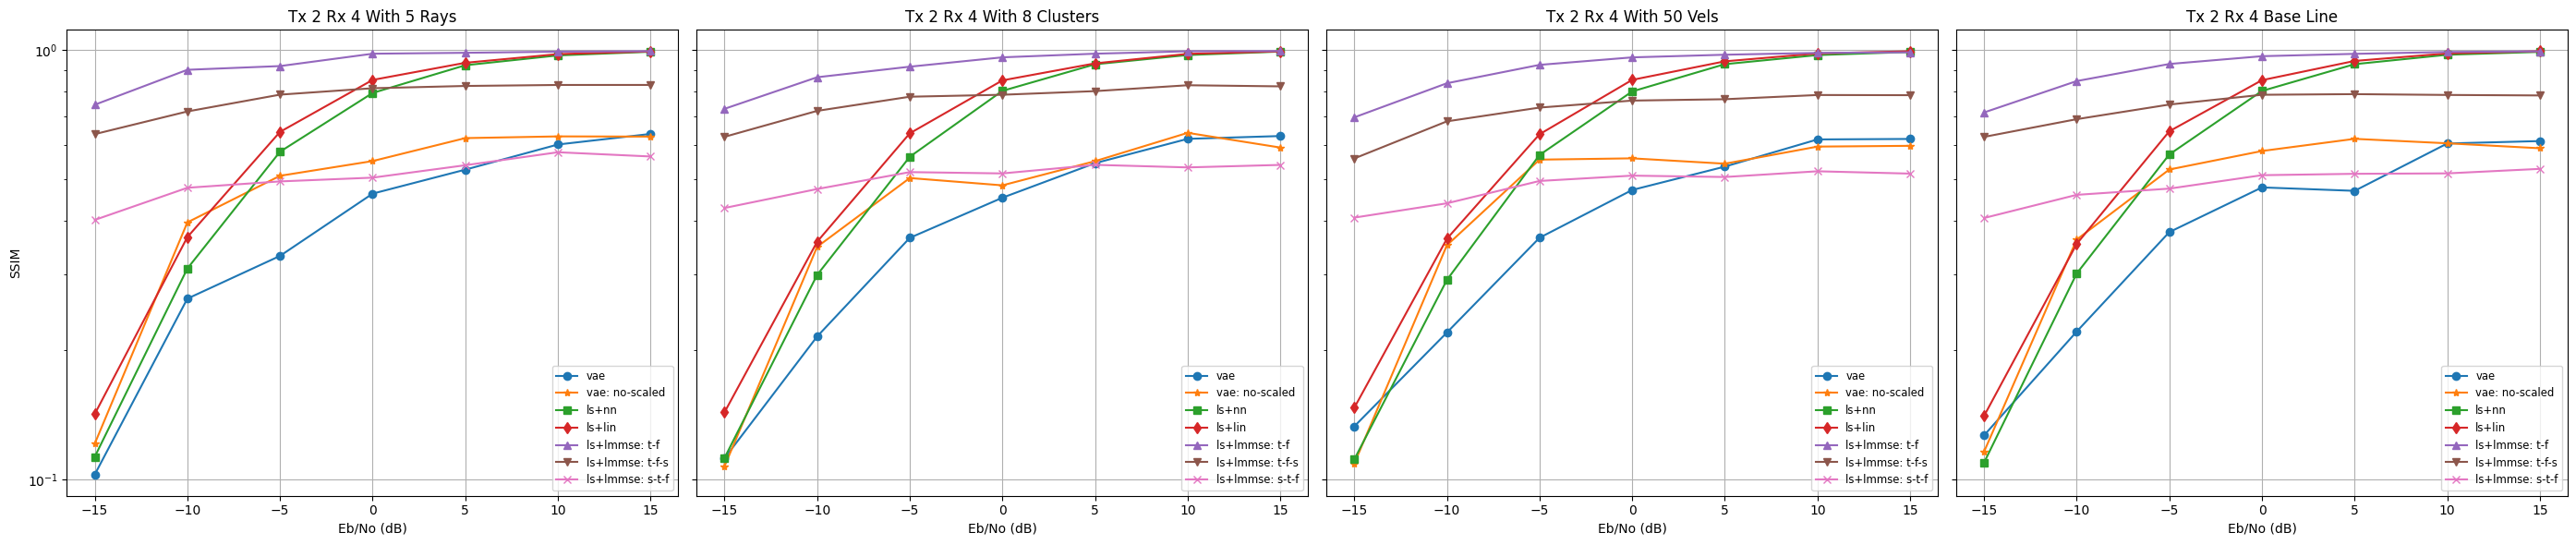

In [17]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON data from time.json
with open(f"{root_dir}/eval/ssim.json", "r") as f:
    data = json.load(f)


# Antenna configs and their display titles
antenna_configs = list(data.keys())
print(antenna_configs)
titles = [
    cfg.replace("_", " ")
    .replace("txant", "TX")
    .replace("rxant", "RX")
    .replace("with", "with")
    .title()
    for cfg in antenna_configs
]

# Define Eb/No range
ebno_range = list(range(-15, 20, 5))

# Methods and plot markers
methods = [
    "vae",
    "vae: no-scaled",
    "ls+nn",
    "ls+lin",
    "ls+lmmse: t-f",
    "ls+lmmse: t-f-s",
    "ls+lmmse: s-t-f",
]
markers = ["o-", "*-", "s-", "d-", "^-", "v-", "x-"]

# Create 1-row, 4-column plot
fig, axes = plt.subplots(1, 4, figsize=(28, 6), sharey=True)

for j, (ant_config, ax) in enumerate(zip(antenna_configs, axes)):
    # Speed is 50 only for '50_vels', otherwise 0
    speed = "50" if "50_vels" in ant_config else "0"

    ebno_values = []
    nmse_values = {method: [] for method in methods}

    # Loop through SNR values
    for ebno_db in ebno_range:
        key = f"speed_{speed}_ebno_db_{ebno_db}"
        if key in data[ant_config]:
            ebno_values.append(ebno_db)
            for method in methods:
                nmse_values[method].append(data[ant_config][key][method])

    ebno_values = np.array(ebno_values)

    # Plot each method
    for k, method in enumerate(methods):
        nmse = np.array(nmse_values[method])
        ax.semilogy(ebno_values, nmse, markers[k], label=method)

    ax.set_title(f"{titles[j]}")
    ax.set_xlabel("Eb/No (dB)")
    if j == 0:
        ax.set_ylabel("SSIM")
    ax.grid(True)
    ax.legend(fontsize="small")

plt.tight_layout()
plt.show()